Imports, loading data set, visualising data set, and setting up for analysis. The goal of this project is to utilize machine learning to devise meaningful ways of classifying or predicting arrythmic ECG signals.

In [2]:
import os
import glob
import re
import wfdb as wf
from wfdb import processing
import numpy as np
import pandas as pd
from collections import Counter
from numpy import matmul, transpose
from matplotlib import pyplot as plt
from scipy import signal
from scipy.sparse import identity
from scipy.fftpack import fft, ifft
from scipy.signal import butter, lfilter, argrelextrema
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score as R2, accuracy_score
from sklearn.model_selection import train_test_split as TTS, GridSearchCV
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier as RFC, GradientBoostingClassifier as GBC
from sklearn import svm

samplenumber=100000    #sample size for analysis

filenames = glob.glob('DataFiles/*.dat') #reading files from DataFiles folder
pchannelb=[] #initiating arrays
file_nums=[]
pfreq=[]
recordall=[]
annall=[]
pchannel=[]

for i, s in enumerate(filenames):                 
    num_str = re.search("(\d+).dat",  filenames[i]) 
    file_nums.append(num_str.group(1)) #extracting the numbering system of the data files, saving them to an array for calling them in the future 
    
for j, k in enumerate(file_nums):
    record = wf.rdrecord('Datafiles/'+file_nums[j], sampto=samplenumber)
    ann = wf.rdann('DataFiles/'+file_nums[j], 'atr', sampto=samplenumber) #reading the data and annotation files
    if record.sig_name[0] == 'MLII':
        pchannelb.append(record.p_signal[:,0])
        annall.append(ann)
        recordall.append(record)
        pchannel.append((pchannelb[j] - np.mean(pchannelb[j])) / np.std(pchannelb[j]))
    if record.sig_name[0] == 'V5':
        pchannelb.append(record.p_signal[:,0])
        annall.append(ann)
        recordall.append(record)
        pchannel.append((pchannelb[j] - np.mean(pchannelb[j])) / np.std(pchannelb[j]))
    if record.sig_name[0] == 'V1':
        pchannelb.append(record.p_signal[:,0])
        annall.append(ann)
        recordall.append(record)
        pchannel.append((pchannelb[j] - np.mean(pchannelb[j])) / np.std(pchannelb[j]))
    if record.sig_name[1] == 'MLII':
        pchannelb.append(record.p_signal[:,1])
        annall.append(ann)
        recordall.append(record)
        pchannel.append((pchannelb[j] - np.mean(pchannelb[j])) / np.std(pchannelb[j]))
    if record.sig_name[1] == 'V5':
        pchannelb.append(record.p_signal[:,1])
        annall.append(ann)
        recordall.append(record)
        pchannel.append((pchannelb[j] - np.mean(pchannelb[j])) / np.std(pchannelb[j]))
    if record.sig_name[1] == 'V1':
        pchannelb.append(record.p_signal[:,1])
        annall.append(ann)
        recordall.append(record)
        pchannel.append((pchannelb[j] - np.mean(pchannelb[j])) / np.std(pchannelb[j]))

    #wf.plot_wfdb(record=record, annotation = ann, title='Record '+file_nums[j]+' from MITBIH', plot_sym=True, time_units='seconds', figsize=(30,10)) #plotting all of the files


Finding Peaks. This part utilizes the gqrs function in wfdb to find R peaks. The cell following uses a custom algorithm to find all local minima and maxima. Annotations inherent in the data serves the same purpose. Currently the peaks found isn't used for the other steps below, but is an important part of develop if we wish to extract features from new data. Annotations are used currently for data preparation, and this will substitute that in the absence of annotations.

C:\Anaconda3\lib\site-packages\wfdb\processing\hr.py:35: RuntimeWarning: divide by zero encountered in double_scalars
  hr = 60000.0 / rr


Example of Gqrs detected peak indices: [197, 487, 803, 1126, 1429, 1738, 2039, 2343, 2639, 2960, 3277, 3578, 3886, 4193, 4493, 4785, 5100, 5417, 5724, 6044, 6341, 6636, 6933, 7260, 7577, 7577, 7883, 8194, 8498, 8801, 9102, 9422, 9731, 10041, 10361, 10668, 10969, 11274, 11603, 11934, 12252, 12572, 12887, 13195, 13512, 13843, 14166, 14479, 14798, 15101, 15402, 15716, 16033, 16359, 16662, 16972, 17272, 17565, 17886, 18208, 18208, 18516, 18821, 19142, 19449, 19748, 20069, 20394, 20719, 21032, 21345, 21652, 21953, 22284, 22284, 22614, 22941, 22941, 23252, 23566, 23875, 24181, 24501, 24828, 25136, 25453, 25765, 26065, 26368, 26694, 27030, 27354, 27673, 27982, 28298, 28620, 28953, 29282, 29588, 29901, 30212, 30522, 30834, 31157, 31495, 31812, 32128, 32438, 32741, 33070, 33403, 33725, 33725, 34029, 34335, 34647, 34951, 35276, 35603, 35698, 35925, 36241, 36560, 36867, 37169, 37497, 37824, 38134, 38434, 38734, 39034, 39335, 39666, 39986, 40296, 40616, 40930, 41241, 41241, 41550, 41874, 42203, 42

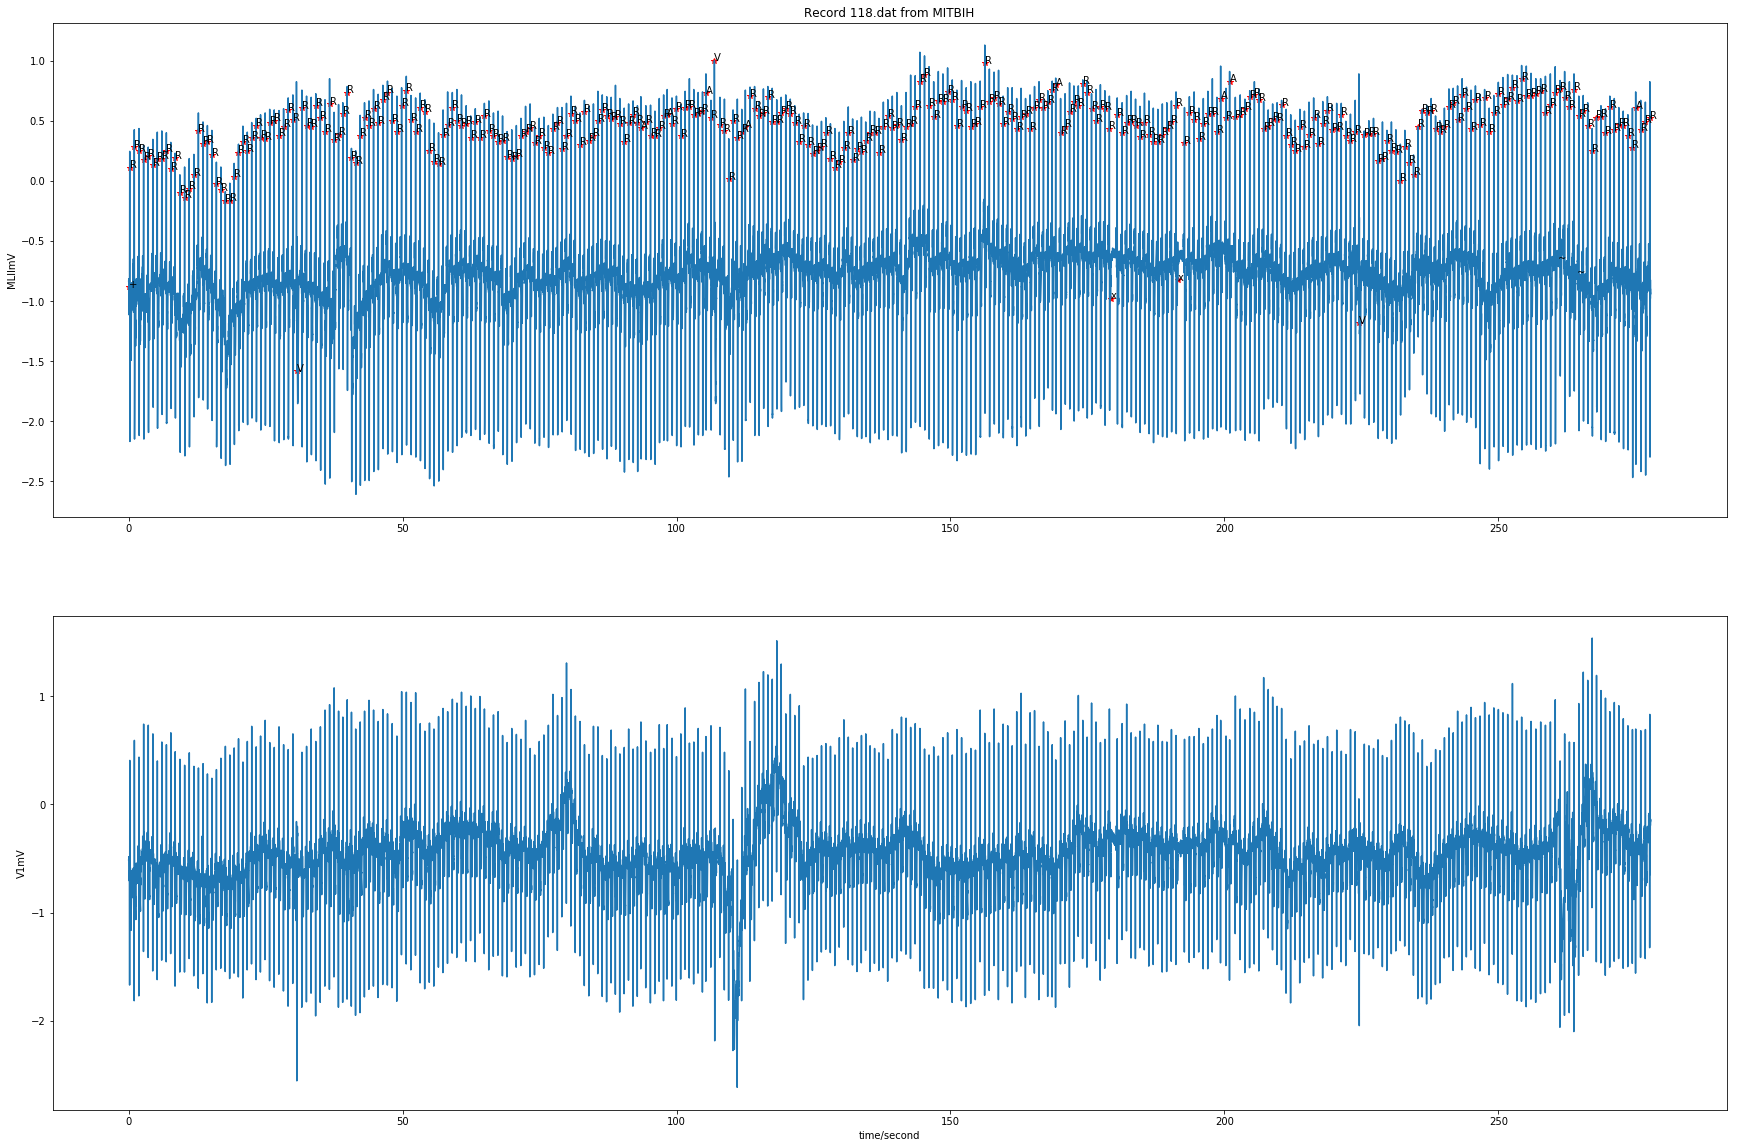

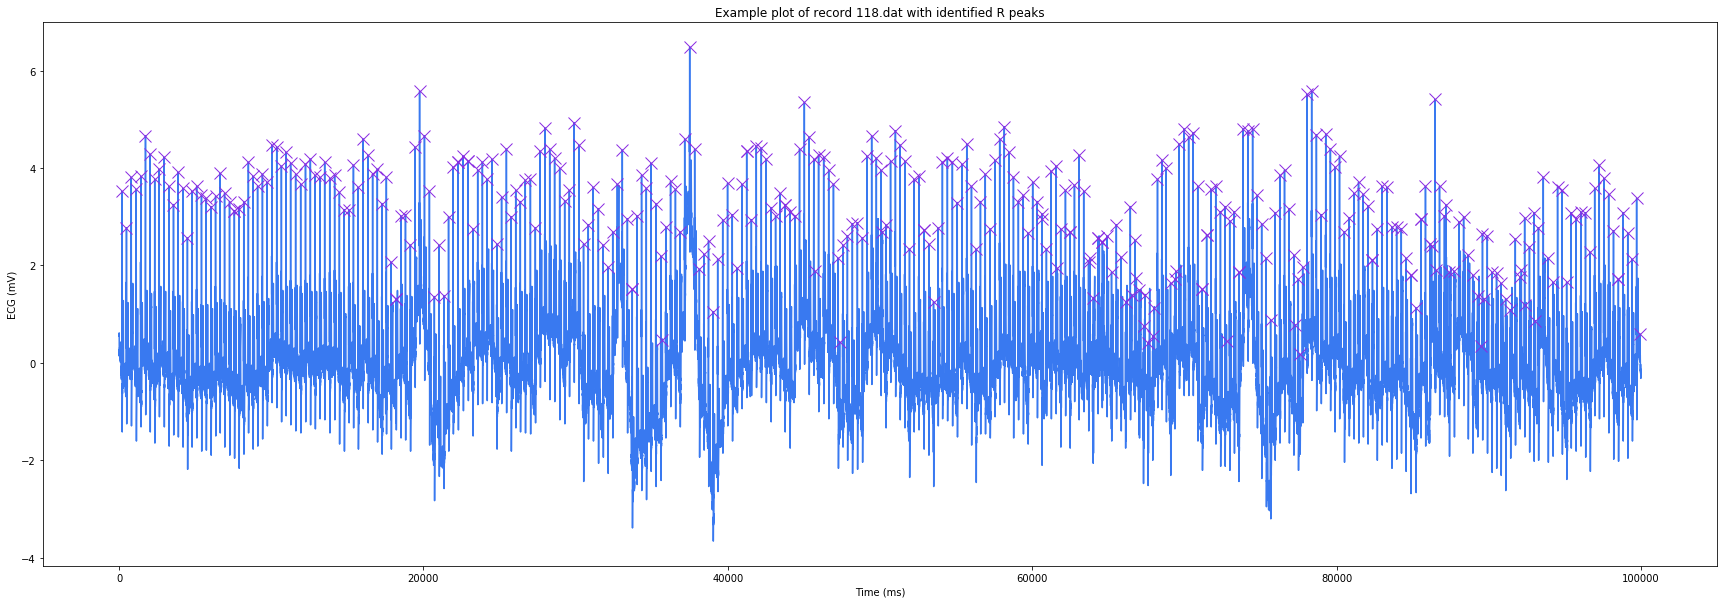

In [3]:
datanumb=31  #which data set to look at

# Use the gqrs algorithm to detect qrs locations in the first channel
search_radius=[]
qrs_inds=[]
peak_inds=[]
hrs=[]
min_bpm = 20
max_bpm = 230
#min_gap = record.fs * 60 / min_bpm
# Use the maximum possible bpm as the search radius

for i in range(len(recordall)):
    search_radius.append(int(recordall[i].fs * 60 / max_bpm))
    qrs_inds.append(processing.gqrs_detect(sig=pchannel[i], fs=recordall[i].fs))
    peak_inds.append(processing.correct_peaks(pchannel[i], peak_inds=qrs_inds[i], search_radius=search_radius[i], smooth_window_size=100))
    hrs.append(processing.compute_hr(sig_len=pchannel[i].shape[0], qrs_inds=peak_inds[i], fs=recordall[i].fs)) #find heart beat for later feature extraction

print('Example of Gqrs detected peak indices:', sorted(peak_inds[datanumb]))

wf.plot_wfdb(record=recordall[datanumb], annotation = annall[datanumb], title='Record '+str(recordall[datanumb].file_name[0])+' from MITBIH', plot_sym=True, time_units='seconds', figsize=(30,20))
plt.figure(figsize=(30,10))
plt.plot(pchannel[datanumb], color='#3979f0', label='Signal')
plt.plot(peak_inds[datanumb], pchannel[datanumb][peak_inds[datanumb]], 'rx', marker='x', color='#8A2BE2', label='Peak', markersize=12)
plt.title('Example plot of record '+str(recordall[datanumb].file_name[0])+' with identified R peaks')
plt.xlabel('Time (ms)')
plt.ylabel('ECG (mV)')
plt.tick_params('y')

Planned extraction of features based on peak detection. This section finds meaningful maxima/minima outside of R peaks (such as P, Q, S, T). Features could be used for sections below in place of data-specific annotations.

[   13    68   369   674   980  1284  1587  1879  2175  2475  2766  3054
  3364  3674  3978  4282  4580  4883  5171  5464  5762  6057  6351  6644
  6929  7215  7506  7793  8082  8378  8664  8966  9266  9565  9875 10178
 10480 10789 11046 11383 11687 11991 12294 12595 12898 13199 13497 13790
 14071 14359 14638 14916 15209 15497 15789 16090 16393 16701 17006 17313
 17622 17933 18243 18548 18854 19157 19459 19761 20055 20360 20655 20957
 21267 21566 21868 22176 22474 22777 23076 23373 23667 23968 24272 24566
 24863 25169 25473 25775 26078 26375 26674 26976 27278 27575 27873 28177
 28469 28767 29060 29350 29648 29947 30240 30537 30830 31121 31412 31704
 31986 32272 32560 32850 33141 33429 33656 33983 34290 34578 34864 35151
 35385 35700 35993 36277 36563 36843 37131 37419 37706 37931 38260 38488
 38850 39146 39428 39713 39994 40284 40520 40827 41126 41413 41707 41998
 42286 42582 42876 43175 43473 43766 44061 44350 44642 44935 45231 45522
 45810 46111 46405 46694 46991 47284 47568 47861 48

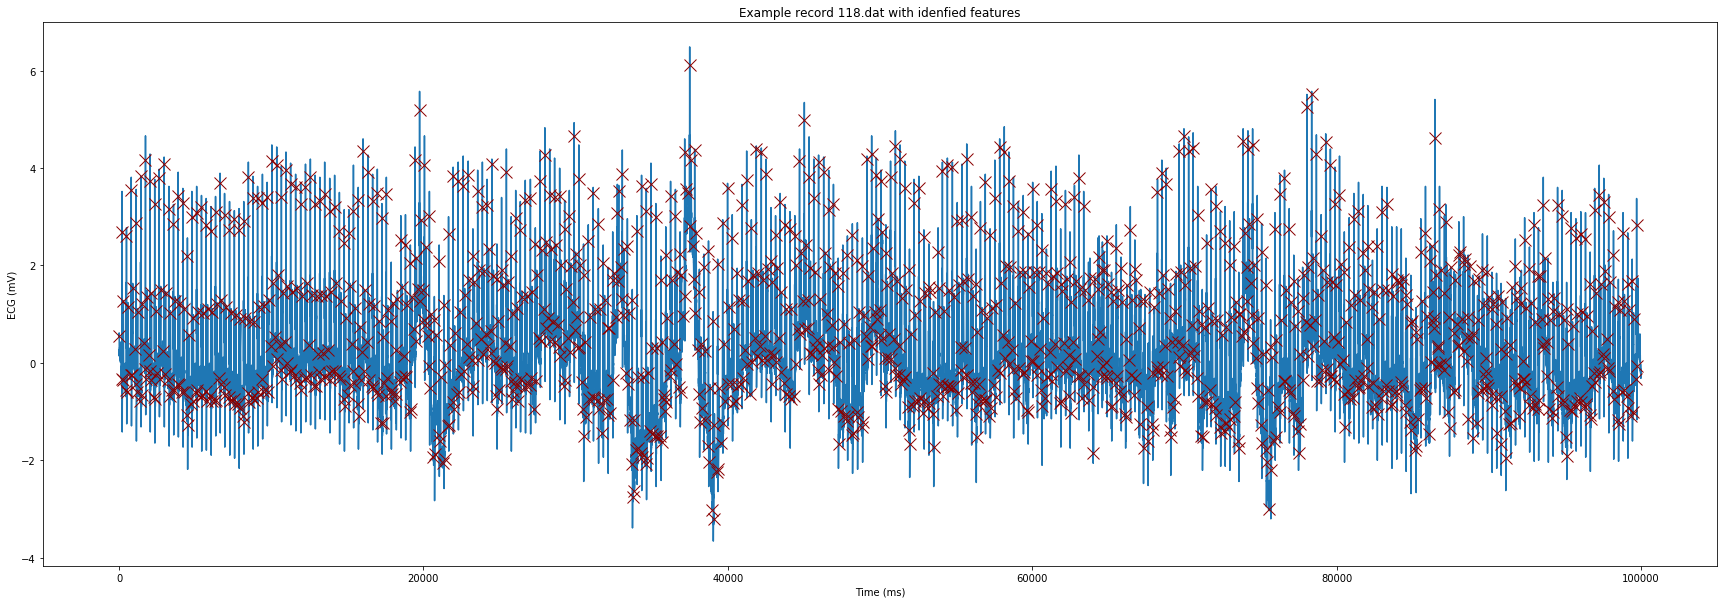

In [4]:
lowcut=.5      #low frequency cutoff for bandpass filter
highcut=3   #high frequency cutoff for bandpass filter
window=10     #window size for moving window integration3

zero_crossings = []

nyquist_freq = 0.5 * record.fs #calculating the nyquist frequency using the sampling frequency
low = lowcut / nyquist_freq #lowpass filtering cutoff
high = highcut / nyquist_freq #highpass filtering cutoff
bf, af = butter(1, [low, high], btype="band")
for i in range(len(pchannel)):
    xf = lfilter(bf, af, pchannel[i]) #bandpass filtering
    yf = np.ediff1d(xf) #deriving the data
    fin = np.convolve(yf, np.ones(window)/window, mode='valid') #moving window average smoothing
    zero_crossings.append(np.where(np.diff(np.sign(fin)))[0]) #find the zero crossings in the differential ie minima and maxima

    mfreq = recordall[i].fs * 0.05 #the minimum datapoints between peaks that's physiologically possible
    mamp = 0.5 #arbitrary amplitude difference to prevent repeated values
    t=0
    l=len(zero_crossings[i])
    while t < l-1:
        if abs(zero_crossings[i][t+1]-zero_crossings[i][t]) < mfreq or abs(pchannel[i][zero_crossings[i][t+1]] - pchannel[i][zero_crossings[i][t]]) < mamp and abs(pchannel[i][zero_crossings[i][t+1]]) > abs(pchannel[i][zero_crossings[i][t]]):
            zero_crossings[i] = np.concatenate((zero_crossings[i][:t], zero_crossings[i][t+1:]))
            l = len(zero_crossings[i])
        elif abs(zero_crossings[i][t+1]-zero_crossings[i][t]) < mfreq or abs(pchannel[i][zero_crossings[i][t+1]] - pchannel[i][zero_crossings[i][t]]) < mamp and abs(pchannel[i][zero_crossings[i][t+1]]) < abs(pchannel[i][zero_crossings[i][t]]):
            zero_crossings[i] = np.concatenate((zero_crossings[i][:t+1], zero_crossings[i][t+2:]))
            l = len(zero_crossings[i])
        else:
            t += 1
            l = len(zero_crossings[i])

        #If two peak values are too close both in time and amplitude, this keeps one value

plt.figure(figsize=(30,10))
plt.plot(pchannel[datanumb])
plt.plot(zero_crossings[datanumb][:-2]-3, pchannel[datanumb][zero_crossings[datanumb][:-2]-3], 'rx', marker='x', color='#8b0000', label='Peak', markersize=12)
anno = [annall[datanumb].sample, annall[datanumb].symbol]
print(anno[0])
plt.title('Example record '+str(recordall[datanumb].file_name[0])+' with idenfied features')
plt.xlabel('Time (ms)')
plt.ylabel('ECG (mV)')
plt.tick_params('y')





Segmentation of data into time frames based on proximity to arrythmic beat. There are two different ways of separating the data. A) The entire dataset is separated into beats along with their annotations and RR distance. In this case, the raw data of each beat and/or some features/statistics could be put into a one vs all classifier. B) The dataset could be separated into arrythmic beats (desired output) and time frames of beats before the arrythmia (input). These inputs and lagged inputs could be reduced in dimentionality using PCA and then be used for training using one vs all, or they could be transformed using techniques such as Fourier transform and used for other prediction algorithms (regression?). Single beats are also possible in this case.

Part A beat type: N
Part B label of beat is N


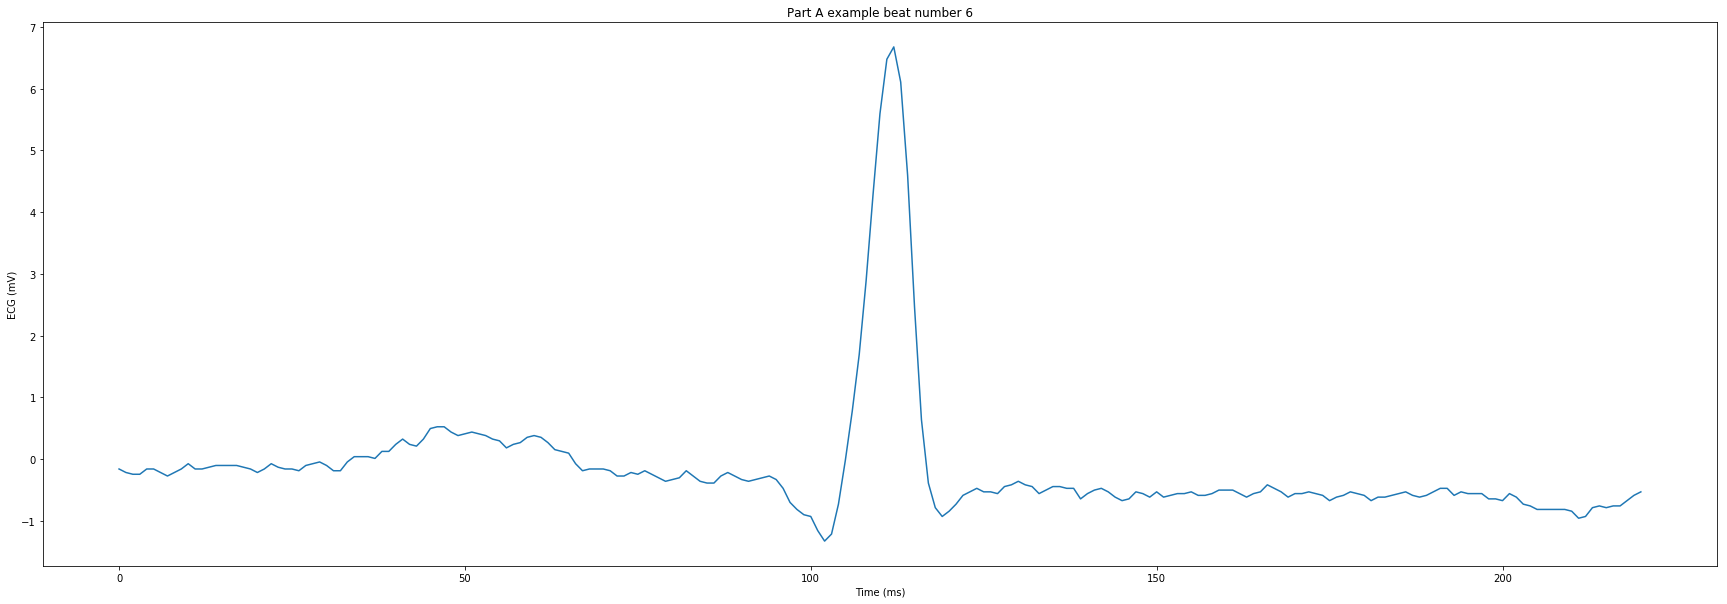

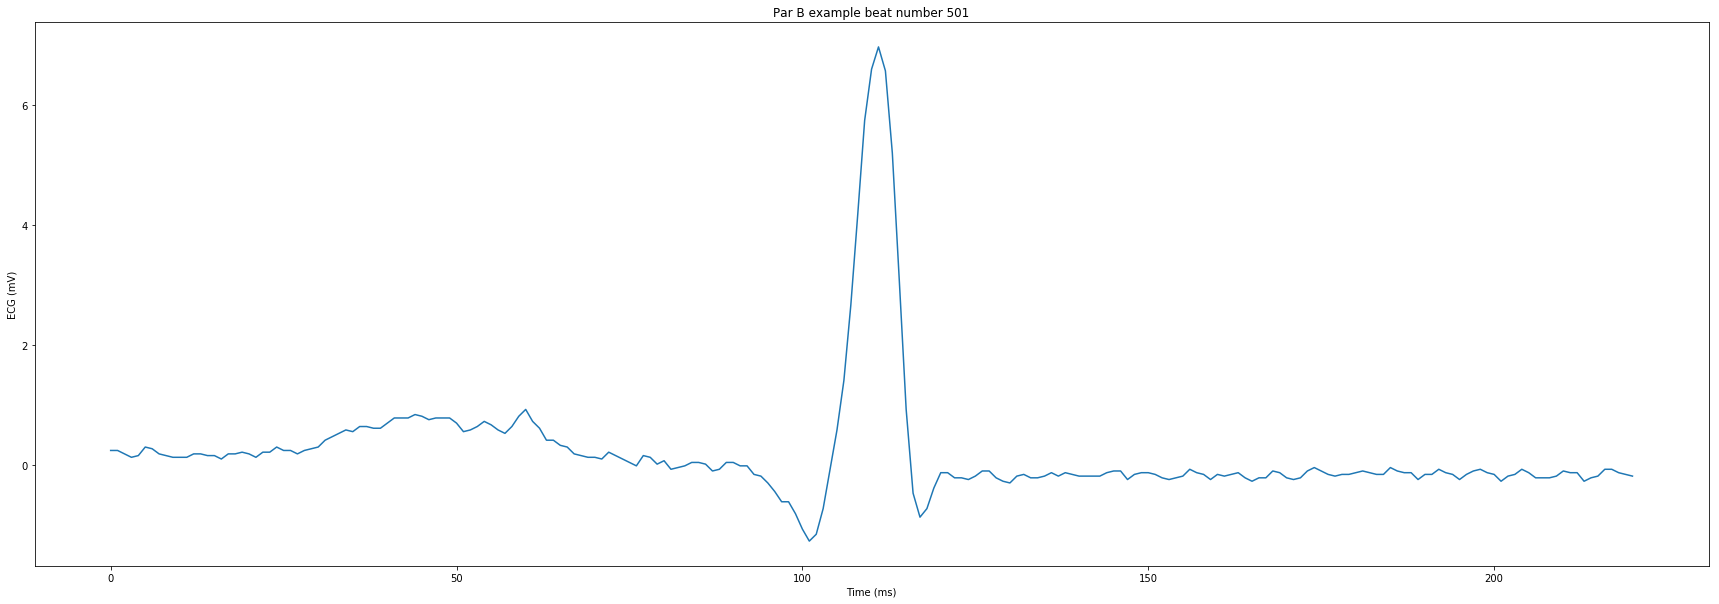

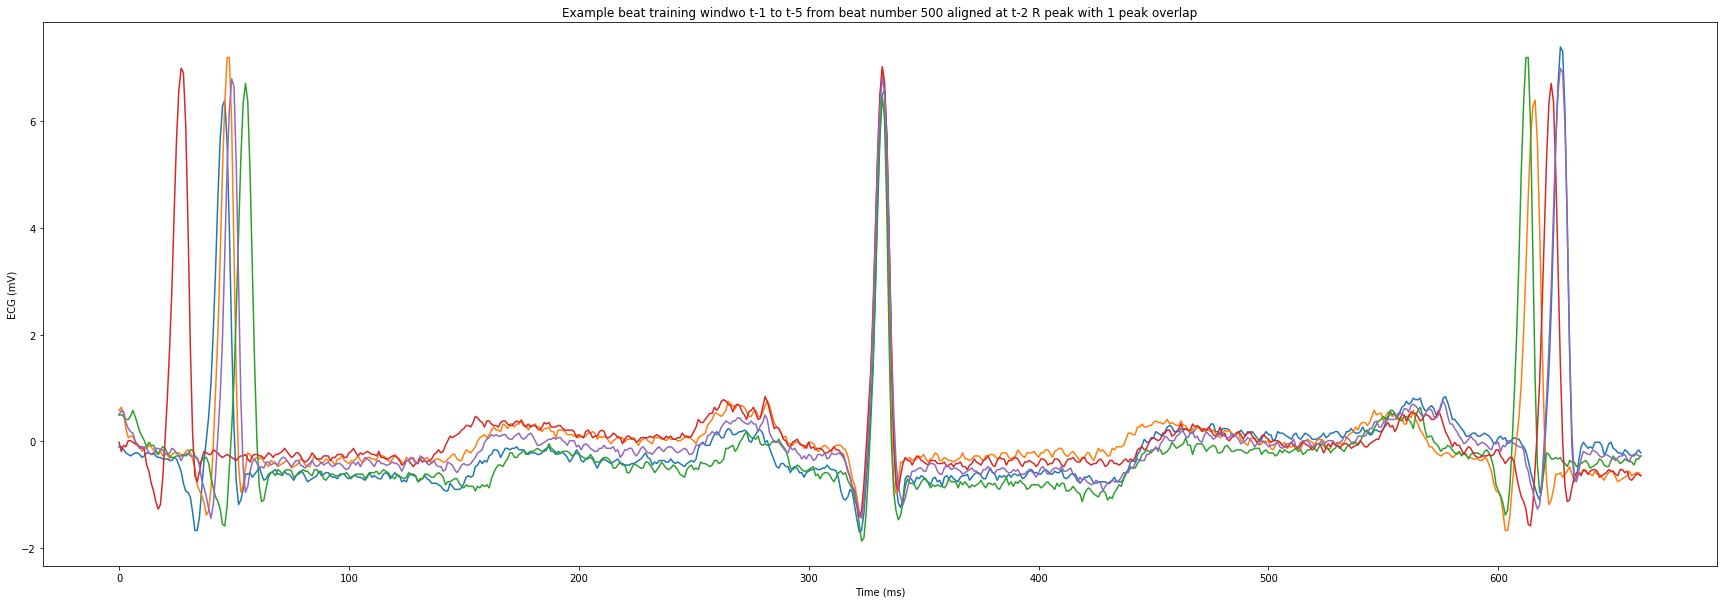

In [5]:
wr = 3 #average amount of heart beats/R peaks for a segment
ws = 2 #peak alignment for the windows counting from the direction of the arrythmic beat
over = 1 #peak overlap allowed between windows

dat = 500 #visualize which arrythmic window for part B
dat2 = 5 #visualize which beat for part A

nrry=[] #setting up list of predicted/expected beats for learning
arry=[] #setting up list of beat annotations for arry

allbeat=[] #a concatination of all individual beats
allbeatan=[] #annotations for allbeat

normalt1=[] #setting up list of input beat windows for arry t-1
normalt2=[] #t-2
normalt3=[] #t-3
normalt4=[] #t-4
normalt5=[] #t-5

annsym=[] #setting up annotation lists without non-beat annotations
annsam=[] #setting up annotation location list without non-beat annotations

Nb=[] #normal beat
Lb=[] #Left bundle branch block beat
Rb=[] #Right bundle branch block beat
Bb=[] #Bundle branch block beat (unspecified)
Ab=[] #Atrial premature beat
ab=[] #Aberrated atrial premature beat
Jb=[] #Nodal (junctional) premature beat
Sb=[] #Supraventricular premature or ectopic beat (atrial or nodal)
Vb=[] #Premature ventricular contraction
rb=[] #R-on-T premature ventricular contraction
Fb=[] #Fusion of ventricular and normal beat
eb=[] #Atrial escape beat
jb=[] #Nodal (junctional) escape beat
nb=[] #Supraventricular escape beat (atrial or nodal)
Eb=[] #Ventricular escape beat
Pb=[] #Paced beat actual symbol /
fb=[] #Fusion of paced and normal beat
Qb=[] #Unclassifiable beat

hry=[]
tlen=[]
for i in range(len(hrs)):
    hrs2 = hrs[i][~np.isnan(hrs[i])]
    hry.append(sum(hrs2[~np.isinf(hrs2)]) / len(hrs2[~np.isinf(hrs2)])) #average heart rate
    tlen.append(int(recordall[i].fs / (hry[i] / 60)))
#Set the total length of the segmented data to specified wr times the average heart rate

ttlen=tlen
tlen=sum(ttlen)/len(ttlen)

abl=['L','R','B','A','a','J','S','V','r','F','e','j','n','E','P','f','Q'] #list of abnormal beats
bbl=['[','!',']','x','(',')','p','t','u','`','%','^','|','~','+','s','T','*','D','=','"','@'] #list of non-beat annotations

#peak_inds are the peak found through calculation while annall[datanumb] is the annotated peaks

for t in range(len(annall)):
    annsymb=[]
    annsamb=[]
    for i in range(len(annall[t].symbol)): #This is to eliminate non-R-peak annotations in the data
        if annall[t].symbol[i] not in bbl:
            annsymb = np.append(annsymb, annall[t].symbol[i])
            annsamb = np.append(annsamb, annall[t].sample[i])
    annsym.append(annsymb)
    annsam.append(annsamb)

for i in range(len(annsym)):
    Nb.append([i for i, x in enumerate(annsym[i]) if x == "N"]) #get indices of all the different beats for later use
    Lb.append([i for i, x in enumerate(annsym[i]) if x == "L"])
    Rb.append([i for i, x in enumerate(annsym[i]) if x == "R"])
    Bb.append([i for i, x in enumerate(annsym[i]) if x == "B"])
    Ab.append([i for i, x in enumerate(annsym[i]) if x == "A"])
    ab.append([i for i, x in enumerate(annsym[i]) if x == "a"])
    Jb.append([i for i, x in enumerate(annsym[i]) if x == "J"])
    Sb.append([i for i, x in enumerate(annsym[i]) if x == "S"])
    Vb.append([i for i, x in enumerate(annsym[i]) if x == "V"])
    rb.append([i for i, x in enumerate(annsym[i]) if x == "r"])
    Fb.append([i for i, x in enumerate(annsym[i]) if x == "F"])
    eb.append([i for i, x in enumerate(annsym[i]) if x == "e"])
    jb.append([i for i, x in enumerate(annsym[i]) if x == "j"])
    nb.append([i for i, x in enumerate(annsym[i]) if x == "n"])
    Eb.append([i for i, x in enumerate(annsym[i]) if x == "E"])
    Pb.append([i for i, x in enumerate(annsym[i]) if x == "/"])
    fb.append([i for i, x in enumerate(annsym[i]) if x == "f"])
    Qb.append([i for i, x in enumerate(annsym[i]) if x == "Q"])


#This first part A is to separate each beat individualy using the average heart rate. Included with it will be other features extracted
#from manual peak detection. Not currently used.

for t in range(len(pchannel)):
    for i in range(len(annsym[t])):
        if (i-ws-4*wr+4*over) > 0 and annsam[t][i-ws-4*wr+4*over]-(wr-ws)*tlen-tlen/2 > 0 and annsam[t][i]+tlen/2 < len(pchannel[t]): #make sure the beats we get are within the window ranges
            allbeat.append(pchannel[t][int(annsam[t][i]-tlen/2):int(annsam[t][i]+tlen/2)])
            #append all beats
            allbeatan.append(annsym[t][i])
            #append all annotations aligning with the beats
    
plt.figure(figsize=(30,10))
plt.plot(allbeat[dat2])
plt.title('Part A example beat number '+str(dat2+1))
plt.xlabel('Time (ms)')
plt.ylabel('ECG (mV)')
plt.tick_params('y')
print('Part A beat type: '+allbeatan[dat2])

#This second part B is to see if the beats before the arrythmic beat could be used to predict the arrythmic beat. This will use raw lagged
#data as the input and the arrythmic beats themselves as the desired output. For data consistency, the data length will be
#normalized to the length of the number of heartbeats specified in wr according to the average heart rate. All of the data
#will also be aligned to specific peaks for data point alignment to optimize training.


for t in range(len(annsym)):
    for i in range(len(annsym[t])):
        if (i-ws-4*wr+4*over) > 0 and annsam[t][i-ws-4*wr+4*over]-(wr-ws)*tlen-tlen/2 > 0 and annsam[t][i]+tlen/2 < len(pchannel[t]): #skips over beats that can't accomdate all time frames
            nrry.append(pchannel[t][int(annsam[t][i]-tlen/2):int(annsam[t][i]+tlen/2)])
            arry.append(annsym[t][i])
            #append all delayed windows
            normalt1.append(pchannel[t][int(annsam[t][i-ws]-(wr-ws)*tlen-tlen/2):int(annsam[t][i-ws]+ws*tlen-tlen/2)]) 
            normalt2.append(pchannel[t][int(annsam[t][i-ws-wr+over]-(wr-ws)*tlen-tlen/2):int(annsam[t][i-ws-wr+over]+ws*tlen-tlen/2)])
            normalt3.append(pchannel[t][int(annsam[t][i-ws-2*wr+2*over]-(wr-ws)*tlen-tlen/2):int(annsam[t][i-ws-2*wr+2*over]+ws*tlen-tlen/2)])
            normalt4.append(pchannel[t][int(annsam[t][i-ws-3*wr+3*over]-(wr-ws)*tlen-tlen/2):int(annsam[t][i-ws-3*wr+3*over]+ws*tlen-tlen/2)])
            normalt5.append(pchannel[t][int(annsam[t][i-ws-4*wr+4*over]-(wr-ws)*tlen-tlen/2):int(annsam[t][i-ws-4*wr+4*over]+ws*tlen-tlen/2)])
            #append all different data windows right before the annotated beats       

plt.figure(figsize=(30,10))
plt.plot(nrry[dat])
plt.title('Par B example beat number '+str(dat+1))
plt.xlabel('Time (ms)')
plt.ylabel('ECG (mV)')
plt.tick_params('y')
print('Part B label of beat is '+arry[dat])

plt.figure(figsize=(30,10))
plt.plot(normalt1[dat])
plt.plot(normalt2[dat])
plt.plot(normalt3[dat])
plt.plot(normalt4[dat])
plt.plot(normalt5[dat])
plt.title('Example beat training windwo t-1 to t-5 from beat number '+str(dat)+' aligned at t-'+str(ws)+' R peak with '+str(over)+' peak overlap')
plt.xlabel('Time (ms)')
plt.ylabel('ECG (mV)')
plt.tick_params('y')


    

In order to prevent the large amount of normal heart beats overshadowing the learning algorithms, we downsample the normal beats to the total amount of arrythmic beats found in the data.

In [6]:
df_a = pd.DataFrame(data=arry, columns=['Beats']) #Set the labels as dataframe for normal vs arrythmic extraction
df_n = pd.DataFrame(data=nrry) #set all data as dataframes for easier downsampling
df_1 = pd.DataFrame(data=normalt1)
df_2 = pd.DataFrame(data=normalt2)
df_3 = pd.DataFrame(data=normalt3)
df_4 = pd.DataFrame(data=normalt4)
df_5 = pd.DataFrame(data=normalt5)
idxN = df_a.index[df_a['Beats'] == 'N'].tolist()
idxA = df_a.index[df_a['Beats'] != 'N'].tolist()
df_a_normal = df_a.loc[idxN] #Split all dataset the same way so that every sample lines up across each dataframe
df_a_arrythmic = df_a.loc[idxA]
df_n_normal = df_n.loc[idxN]
df_n_arrythmic = df_n.loc[idxA]
df_1_normal = df_1.loc[idxN]
df_1_arrythmic = df_1.loc[idxA]
df_2_normal = df_2.loc[idxN]
df_2_arrythmic = df_2.loc[idxA]
df_3_normal = df_3.loc[idxN]
df_3_arrythmic = df_3.loc[idxA]
df_4_normal = df_4.loc[idxN]
df_4_arrythmic = df_4.loc[idxA]
df_5_normal = df_5.loc[idxN]
df_5_arrythmic = df_5.loc[idxA]

idx = np.random.choice(df_a_normal.index, len(df_a_arrythmic), replace=False) #create a random index for downsampling based on the number of arrythmic beats
df_a_downsampled = df_a_normal.loc[idx]
df_n_downsampled = df_n_normal.loc[idx]
df_1_downsampled = df_1_normal.loc[idx]
df_2_downsampled = df_2_normal.loc[idx]
df_3_downsampled = df_3_normal.loc[idx]
df_4_downsampled = df_4_normal.loc[idx]
df_5_downsampled = df_5_normal.loc[idx]

df_a = pd.concat([df_a_downsampled, df_a_arrythmic]).sort_index()
df_n = pd.concat([df_n_downsampled, df_n_arrythmic]).sort_index()
df_1 = pd.concat([df_1_downsampled, df_1_arrythmic]).sort_index()
df_2 = pd.concat([df_2_downsampled, df_2_arrythmic]).sort_index()
df_3 = pd.concat([df_3_downsampled, df_3_arrythmic]).sort_index()
df_4 = pd.concat([df_4_downsampled, df_4_arrythmic]).sort_index()
df_5 = pd.concat([df_5_downsampled, df_5_arrythmic]).sort_index()

arry = np.array(df_a)
nrry = np.array(df_n)
normalt1 = np.array(df_1)
normalt2 = np.array(df_2)
normalt3 = np.array(df_3)
normalt4 = np.array(df_4)
normalt5 = np.array(df_5)

arryb=np.array(arry)
#Set beat annotation to binary for learning later
for n, i in enumerate(arryb):
    if i == 'N':
        arryb[n] = 0
    else:
        arryb[n] = 1

df_a['Beats'].value_counts()

N    8903
R    2200
L    2118
V    2030
/    1563
A     456
F     338
f     173
a      14
Q       5
e       4
J       2
Name: Beats, dtype: int64

Attempts at raw data decomposition for part B: transforming the different time windows from segmentation will allow us to bypass timing restrictions. First to try is Fourier Transform.

Text(0.5,1,'Fourier transforms of t-1 to t-5 time windows for the first arrythmic beat of data #210')

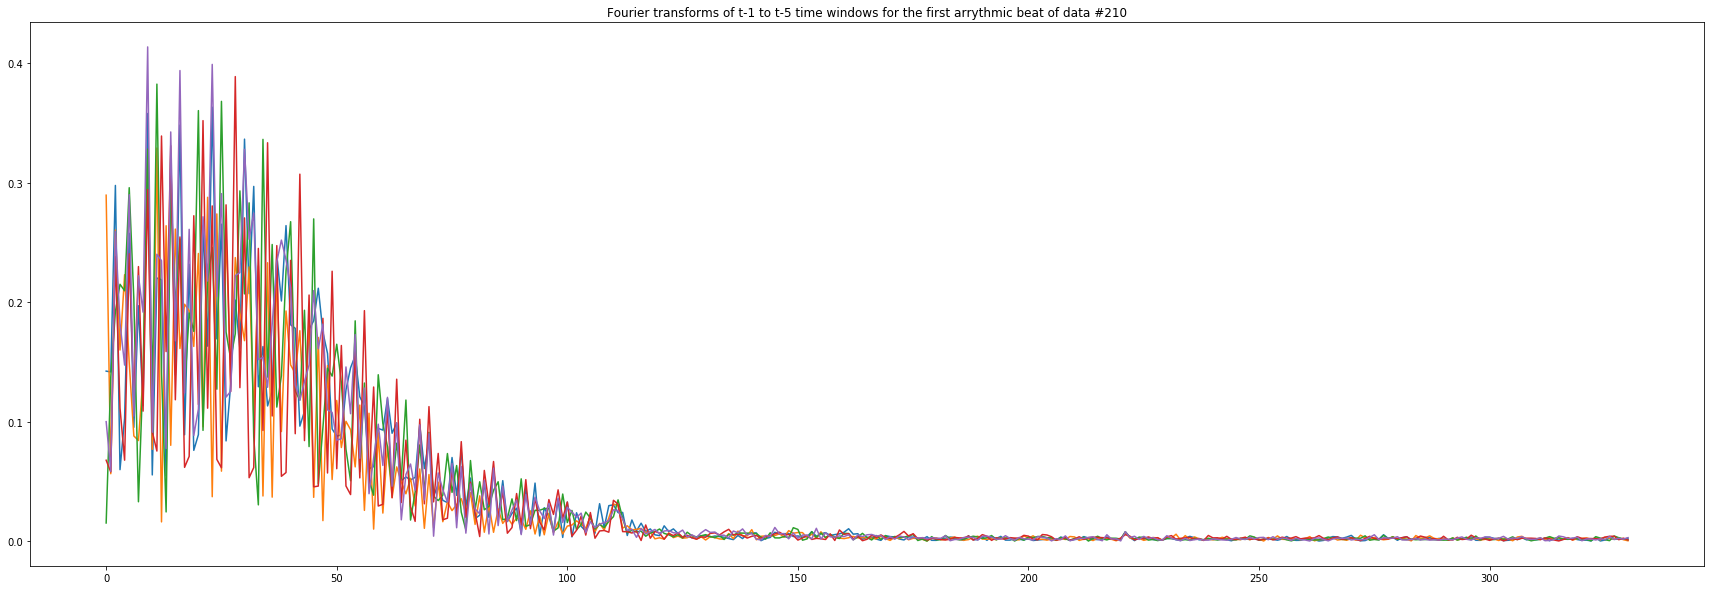

In [7]:
#Fourier transform of normalt raw data windows
fnormalt1=[]
fnormalt2=[]
fnormalt3=[]
fnormalt4=[]
fnormalt5=[]

N = len(normalt1[0]) #number of sample points

for i in range(len(normalt5)):
    try:
        fnormalt1.append(fft(normalt1[i])) #Fourier transform of all data
        fnormalt2.append(fft(normalt2[i]))
        fnormalt3.append(fft(normalt3[i]))
        fnormalt4.append(fft(normalt4[i]))
        fnormalt5.append(fft(normalt5[i]))
    except ValueError:
        pass
plt.figure(figsize=(30,10))
plt.plot(2.0/N * np.abs(fnormalt1[0][:N//2]))
plt.plot(2.0/N * np.abs(fnormalt2[0][:N//2]))
plt.plot(2.0/N * np.abs(fnormalt3[0][:N//2]))
plt.plot(2.0/N * np.abs(fnormalt4[0][:N//2]))
plt.plot(2.0/N * np.abs(fnormalt5[0][:N//2]))
plt.title('Fourier transforms of t-1 to t-5 time windows for the first arrythmic beat of data #'+file_nums[datanumb])

#widths = np.arange(1, 31)
#cwtmatr = signal.cwt(normalt1[dat], signal.ricker, widths)
#plt.figure(figsize=(30,10))
#plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto', vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())

Using the Fourier Transforms above as well as the raw data from part B, this part reduces the complexity of the data using PCA and initiates the linear prediction algorithm in the following cell. The Linear Regression model is simply a fast way of evaluating whether or not our data prep steps worked and isn't useful outside of that goal.

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
C:\Anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


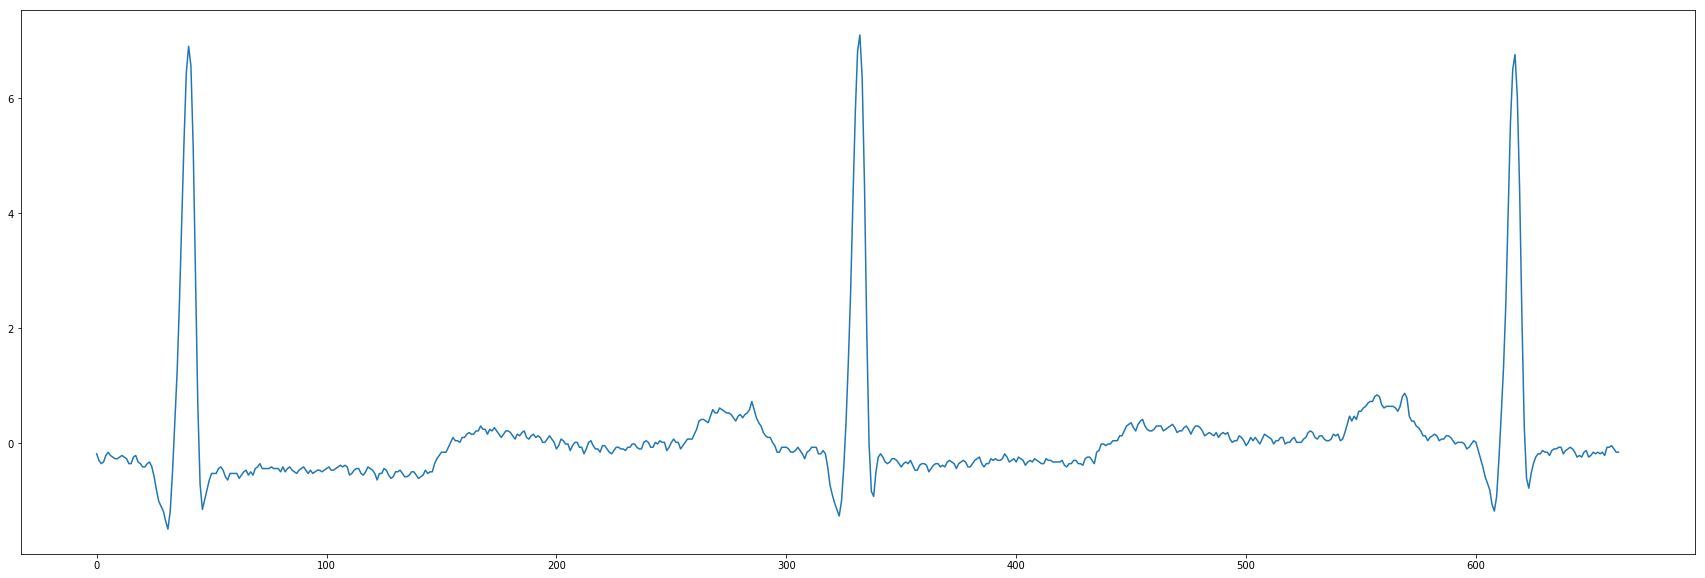

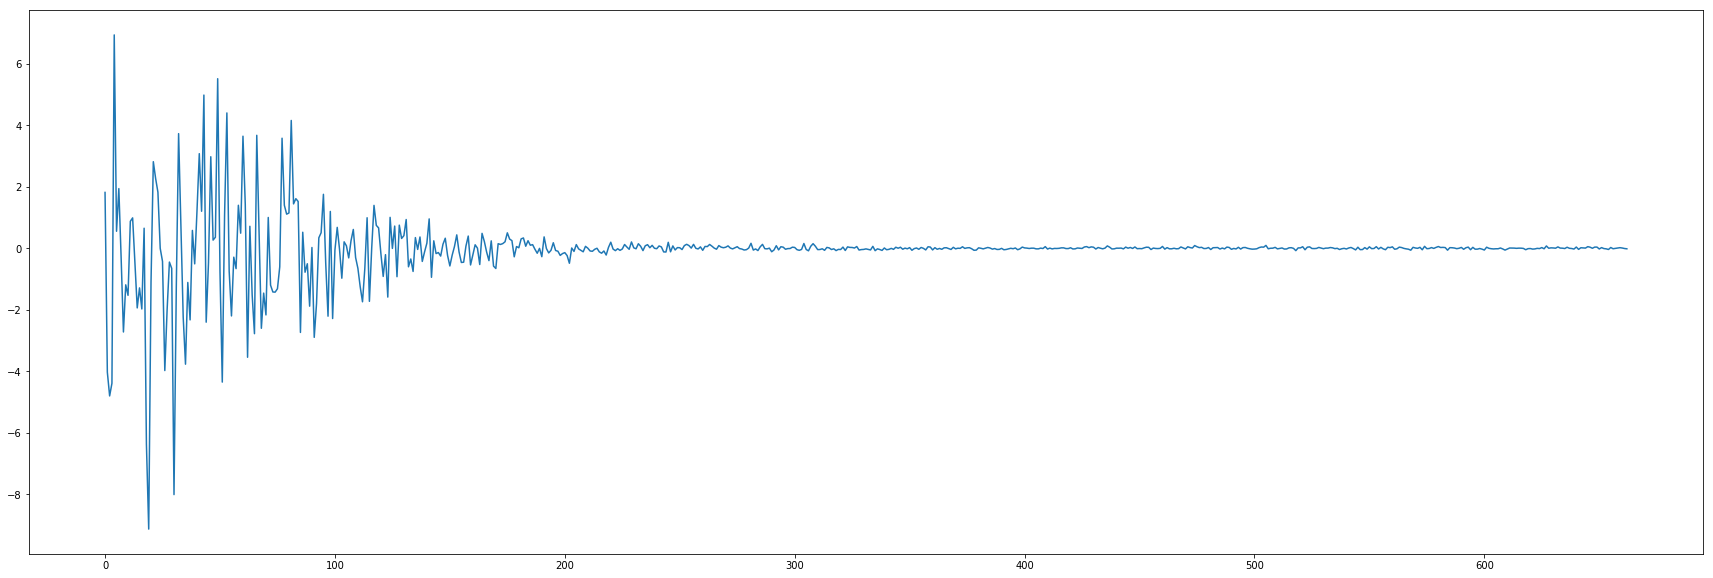

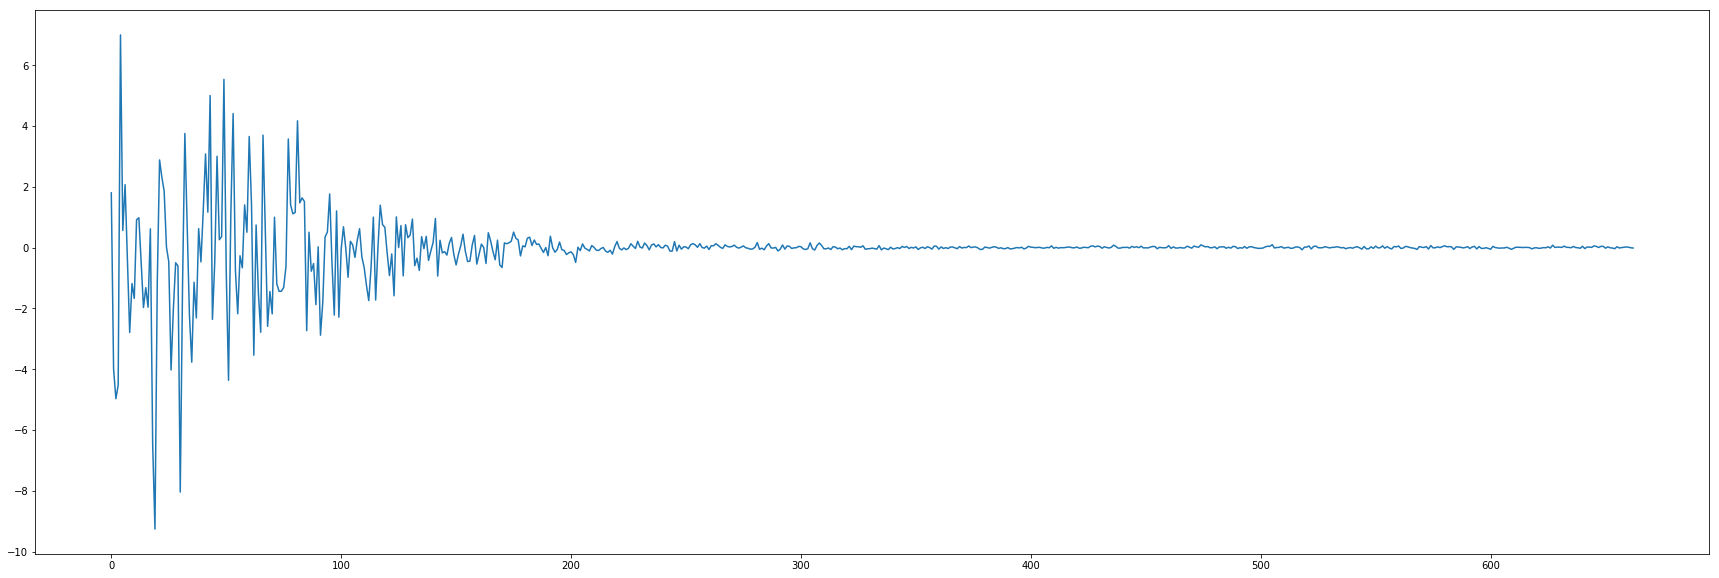

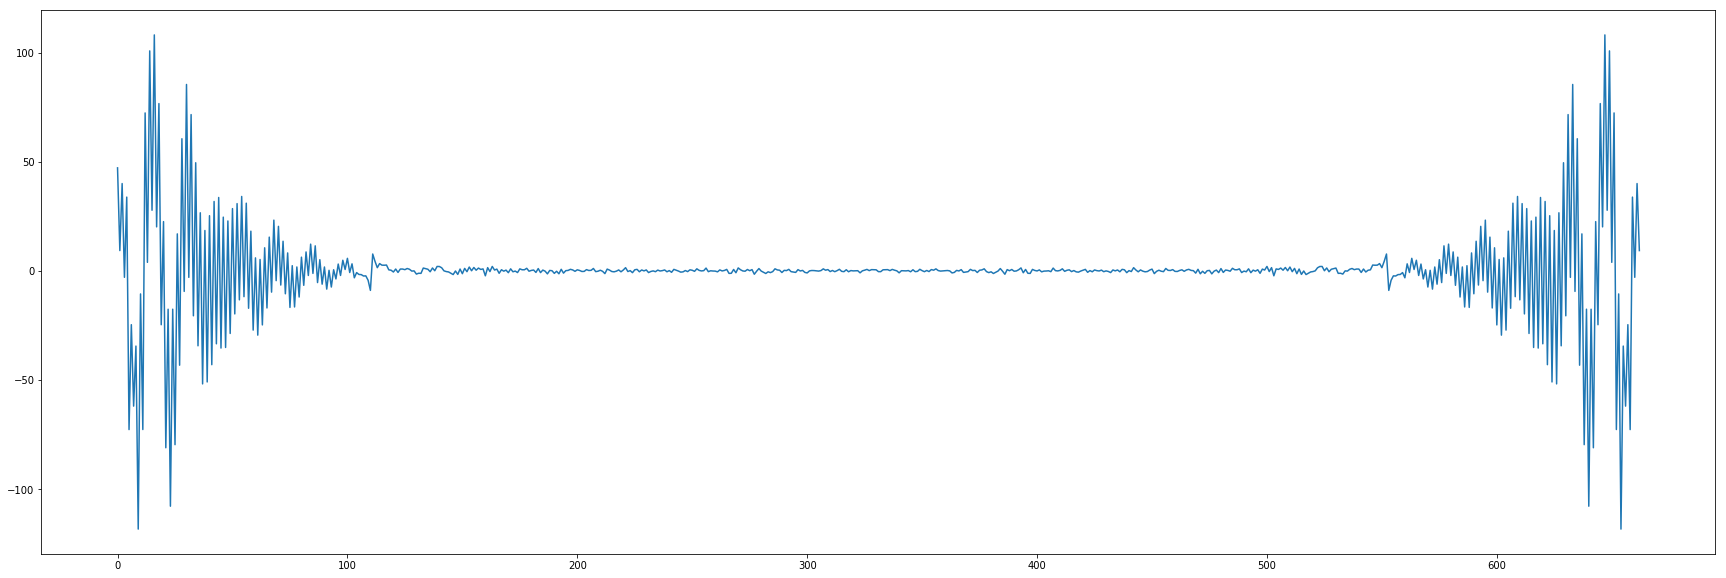

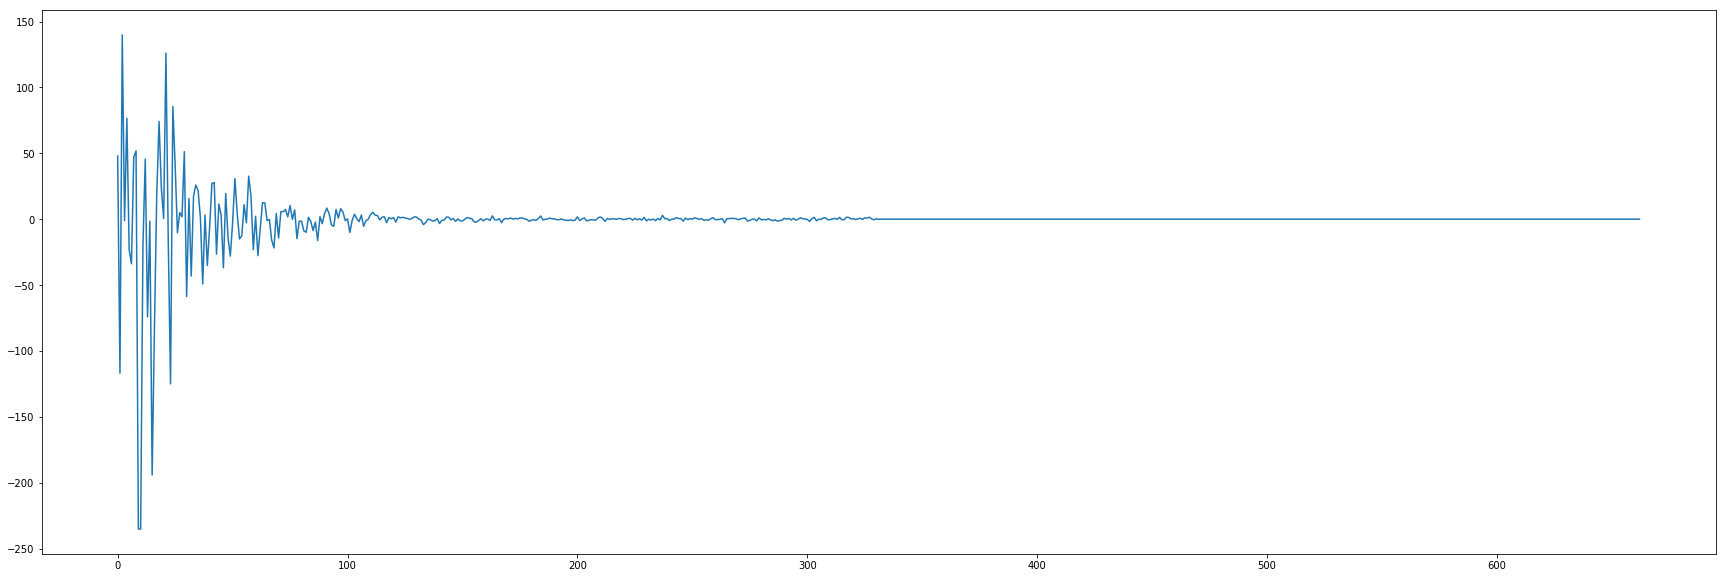

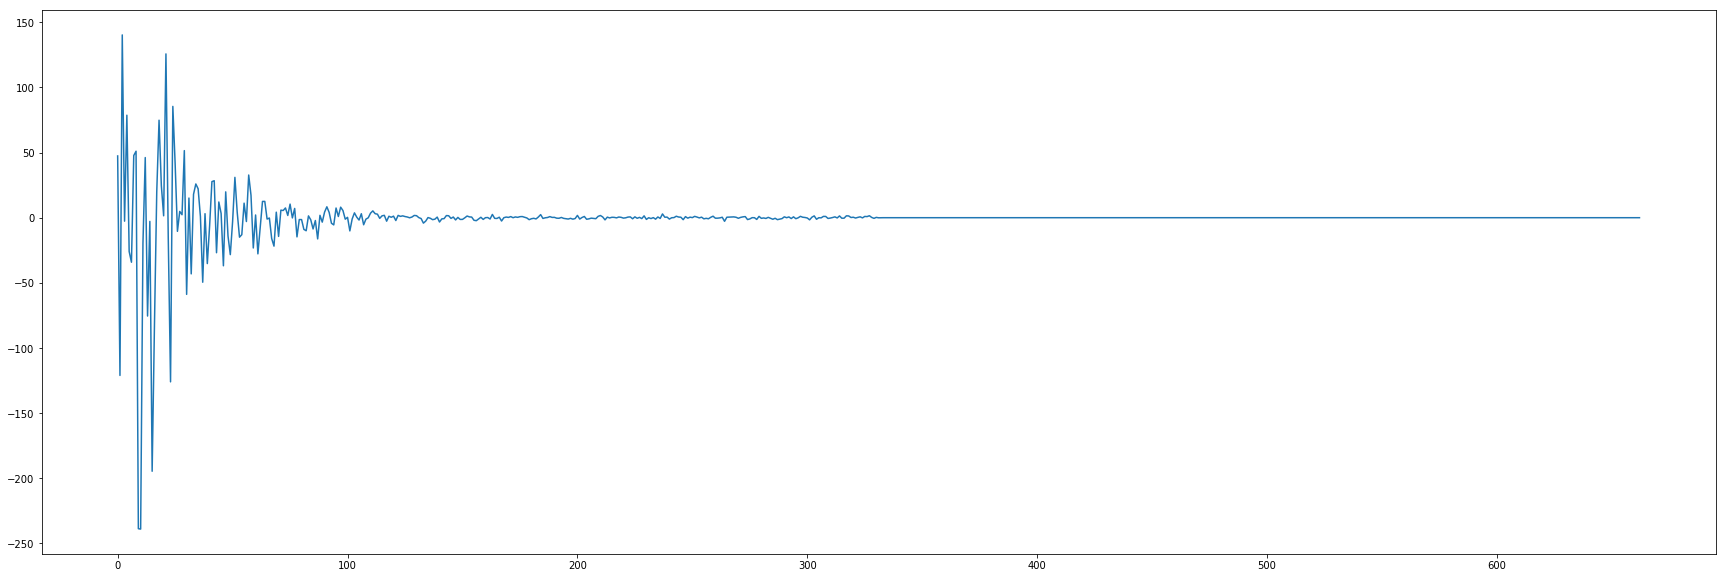

In [8]:
pca = PCA(n_components = len(normalt1[0]))

alln=np.concatenate((np.array(normalt1),np.array(normalt2),np.array(normalt3),np.array(normalt4),np.array(normalt5)),axis=1) #set up an array to learn across all time windows at once
allf=np.concatenate((np.array(fnormalt1),np.array(fnormalt2),np.array(fnormalt3),np.array(fnormalt4),np.array(fnormalt5)),axis=1) #all time windows in the frequency domain

reducedn = pca.fit_transform(alln) #PCA on all time windows
reducednpc = pca.components_ #Get the principal components
coefn = matmul(alln,transpose(reducednpc)) #calculate the weights for learning

reducedn1 = pca.fit_transform(np.array(normalt1)) #PCA on the first time window only
reducedn1pc = pca.components_
coefn1 = matmul(np.array(normalt1),transpose(reducedn1pc))

reducedf = pca.fit_transform(allf) #PCA on all frequency transforms
reducedfpc = pca.components_
coeff = matmul(allf,transpose(reducedfpc))

reducedf1 = pca.fit_transform(np.array(fnormalt1)) #PCA on the frequency domain of the first window only
reducedf1pc = pca.components_
coeff1 = matmul(np.array(fnormalt1),transpose(reducedf1pc))

plt.figure(figsize=(30,10))
plt.plot(normalt1[0])
plt.figure(figsize=(30,10))
plt.plot(reducedn1[0])
plt.figure(figsize=(30,10))
plt.plot(coefn1[0])
plt.figure(figsize=(30,10))
plt.plot(fnormalt1[0])
plt.figure(figsize=(30,10))
plt.plot(reducedf1[0])
plt.figure(figsize=(30,10))
plt.plot(coeff1[0])



The R2 score for LR using raw first window input is: 0.07933397408646979


C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


The R2 score for LR using transformed first window input is: 7.888131039474443e+23
The R2 score for LR using PCA weights of first window input is: 0.07933397408646985
The R2 score for LR using PCA weights of transformed first window input is: 8.058512449711724e+23
The R2 score for LR using all raw inputs is: -0.05175520975697421
The R2 score for LR using all transformed input is: 2.5044021956066496e+23
The R2 score for LR using PCA weights of all raw input is: 0.08339340528080191
The R2 score for LR using PCA weights of all transformed input is: 0.061821657477735784


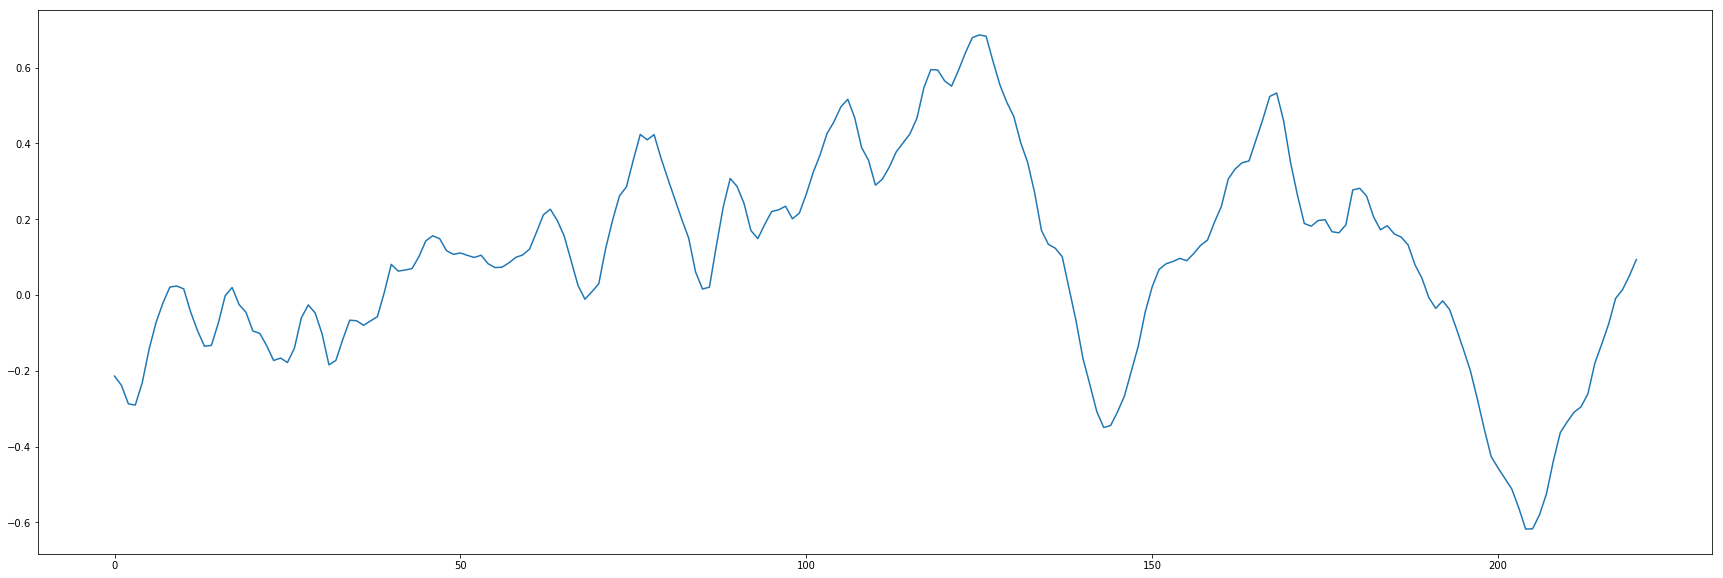

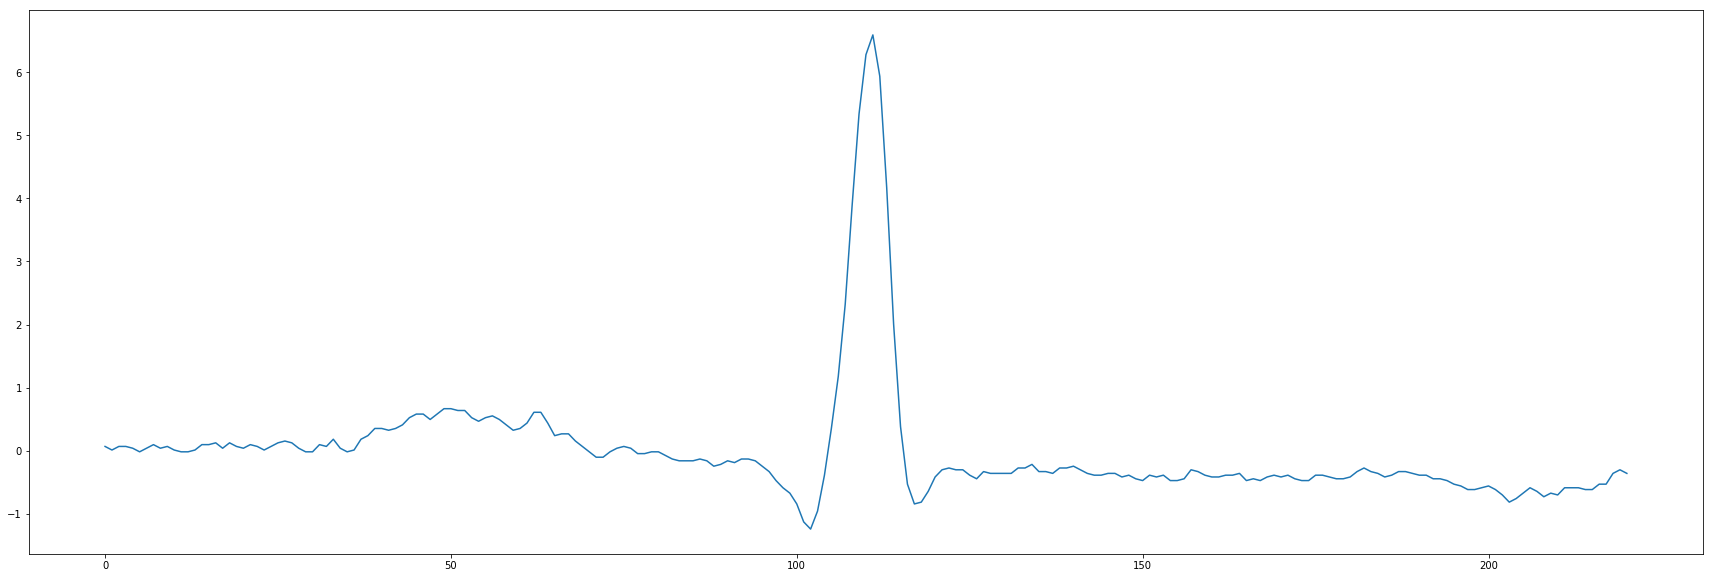

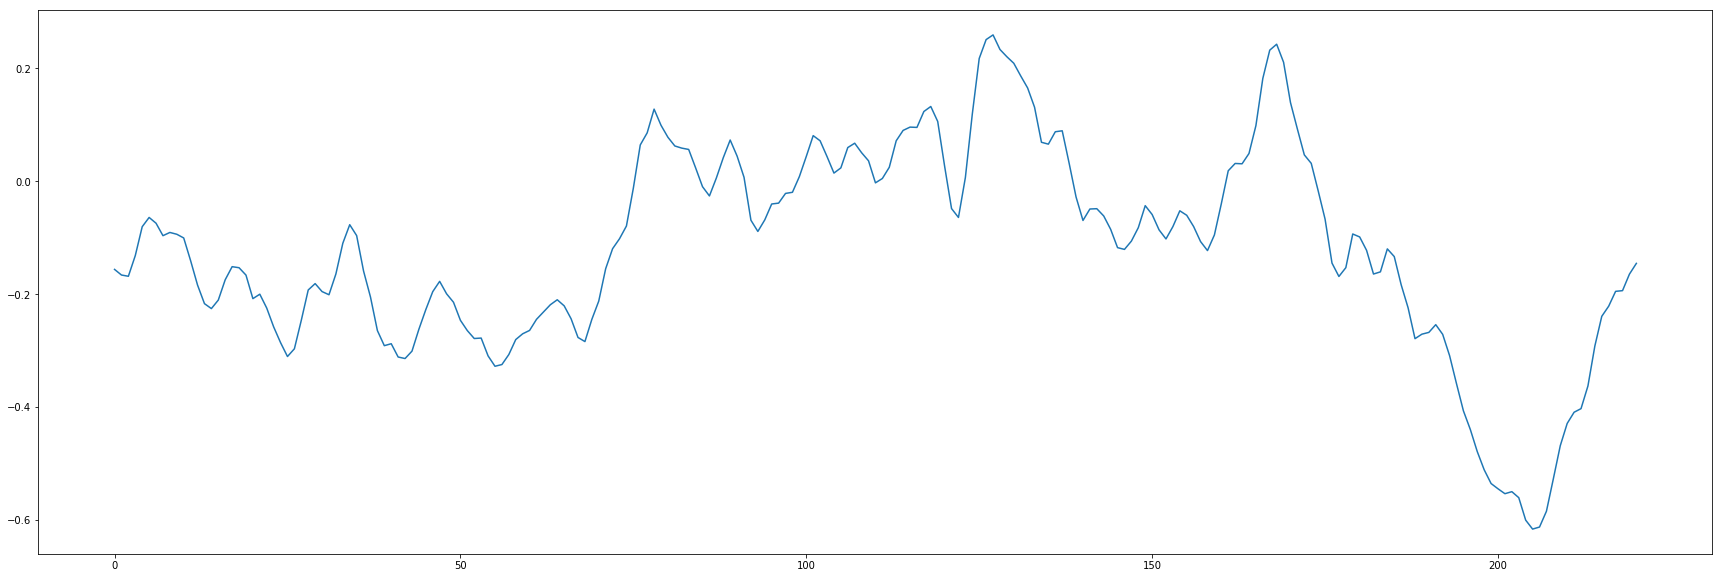

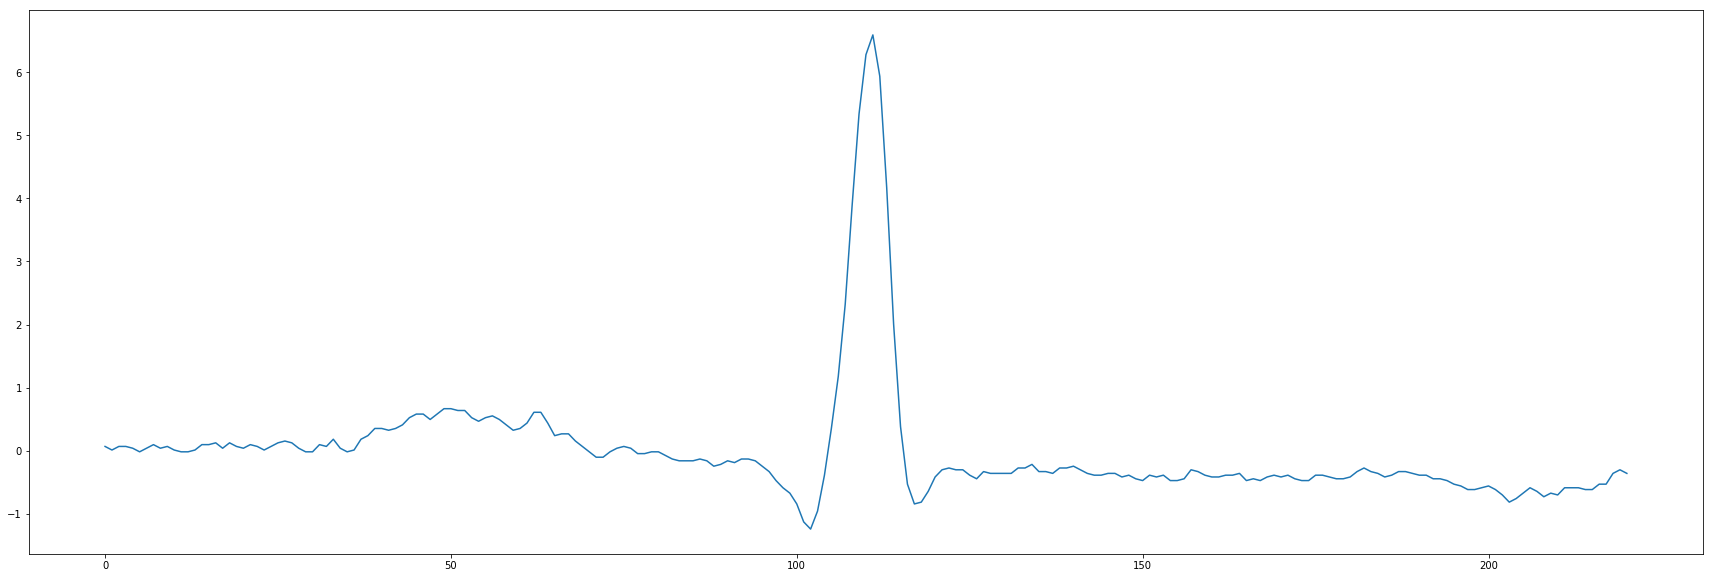

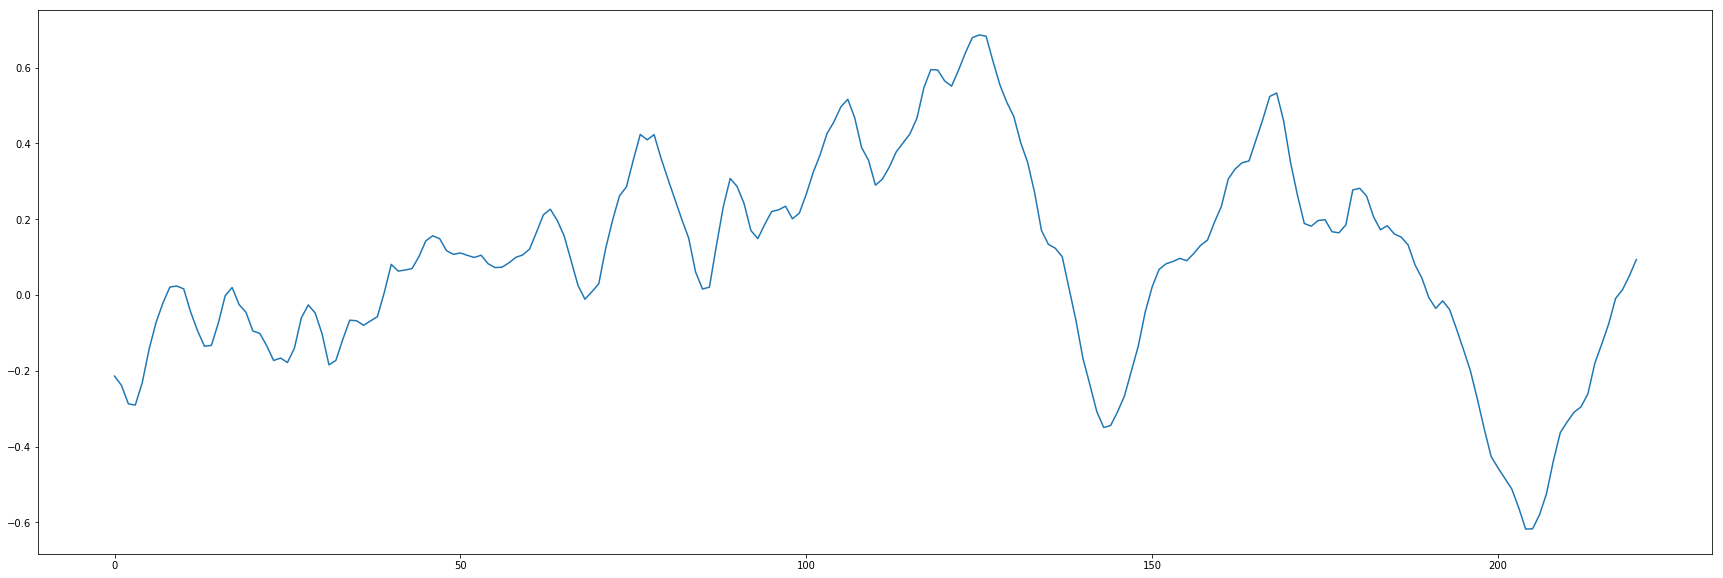

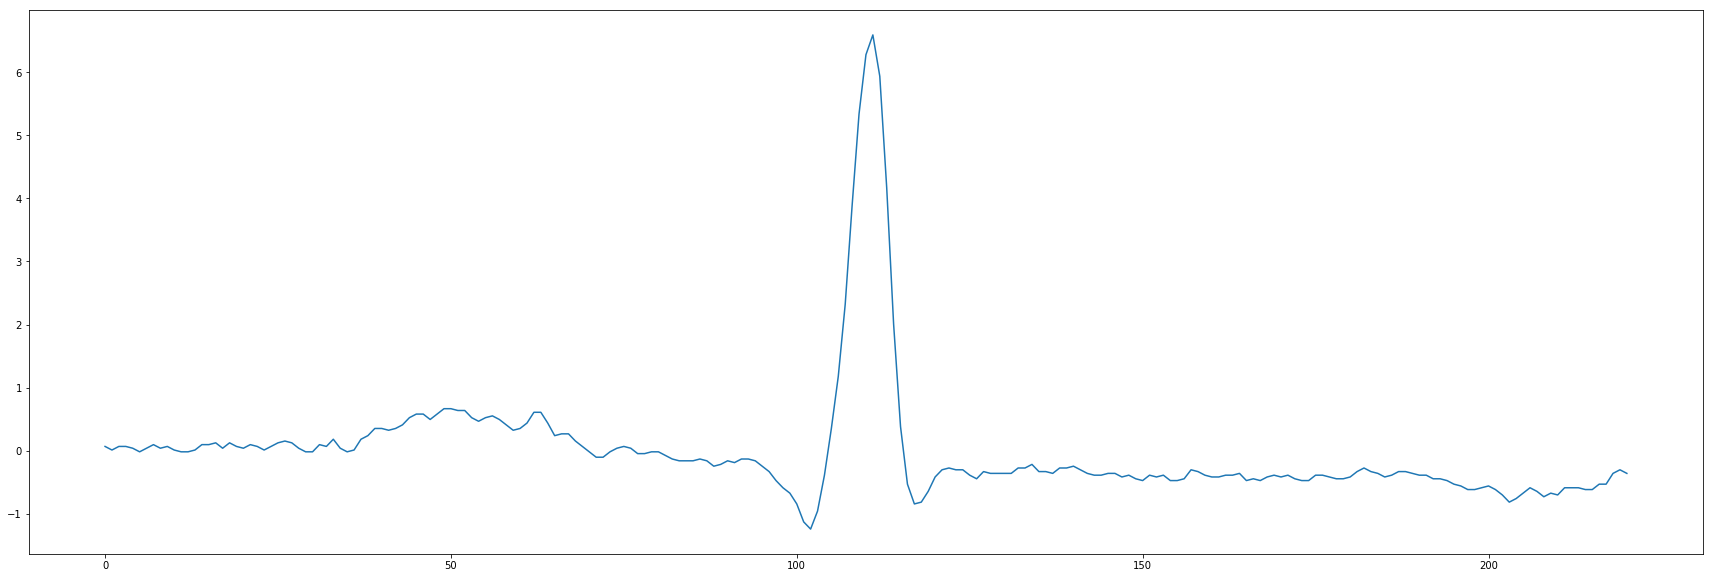

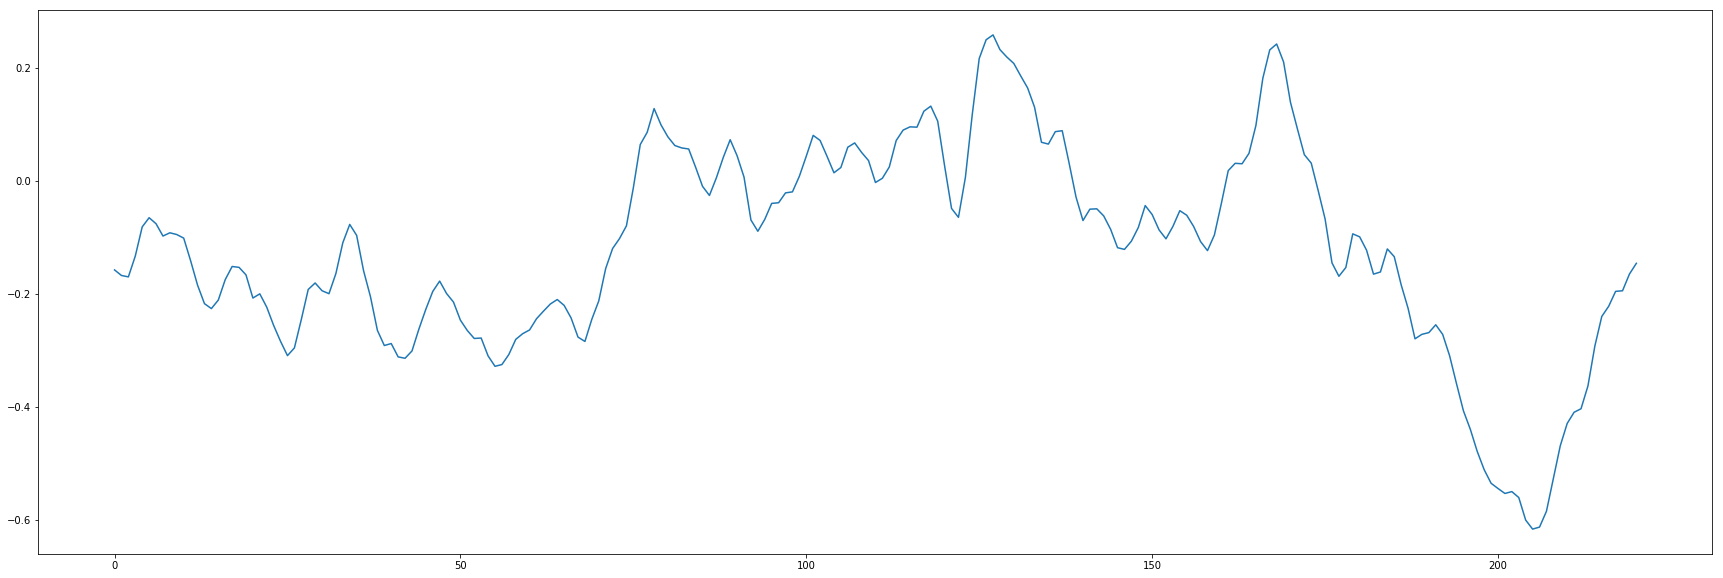

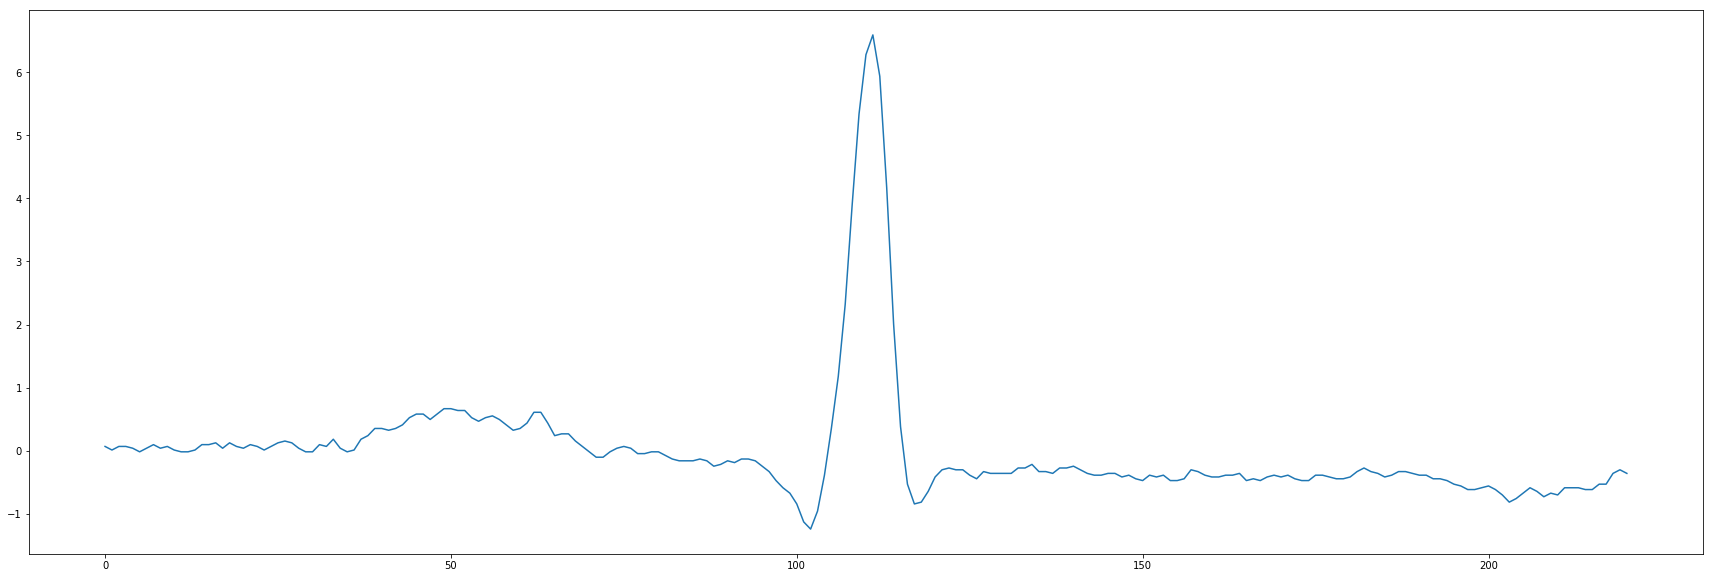

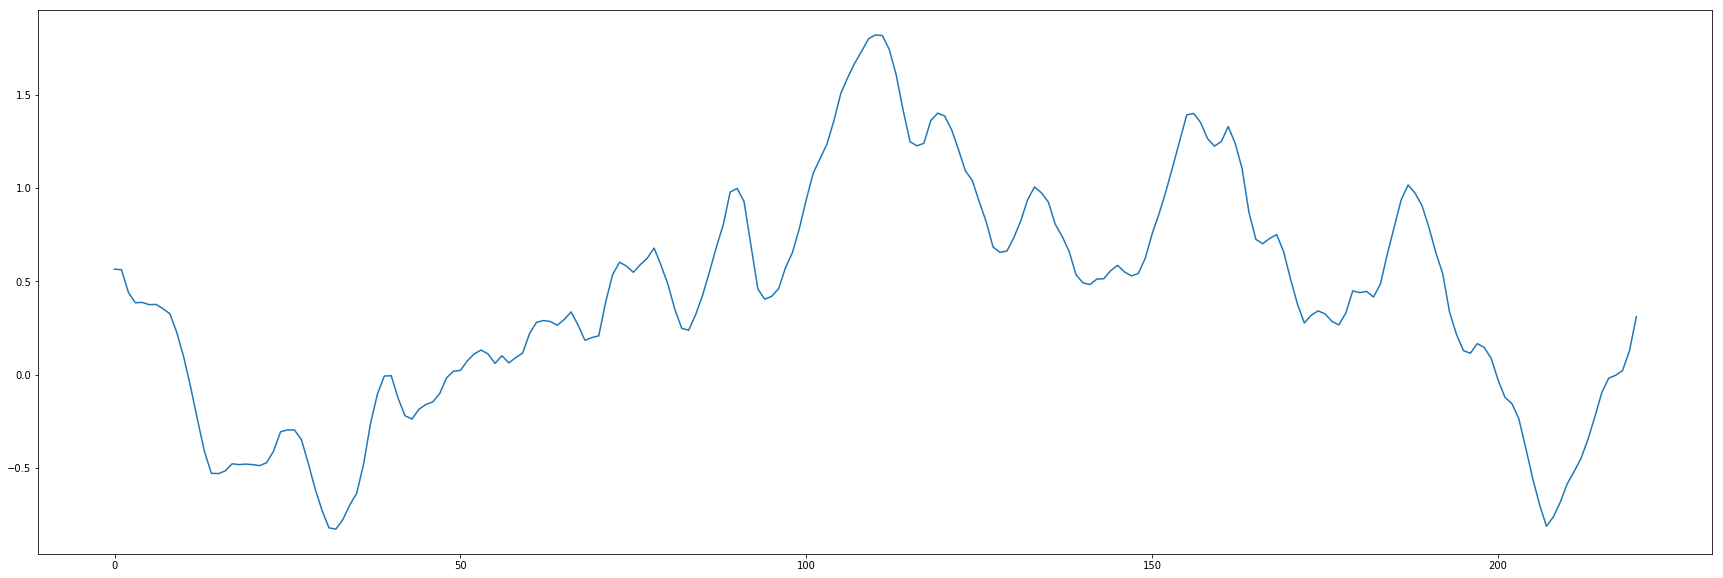

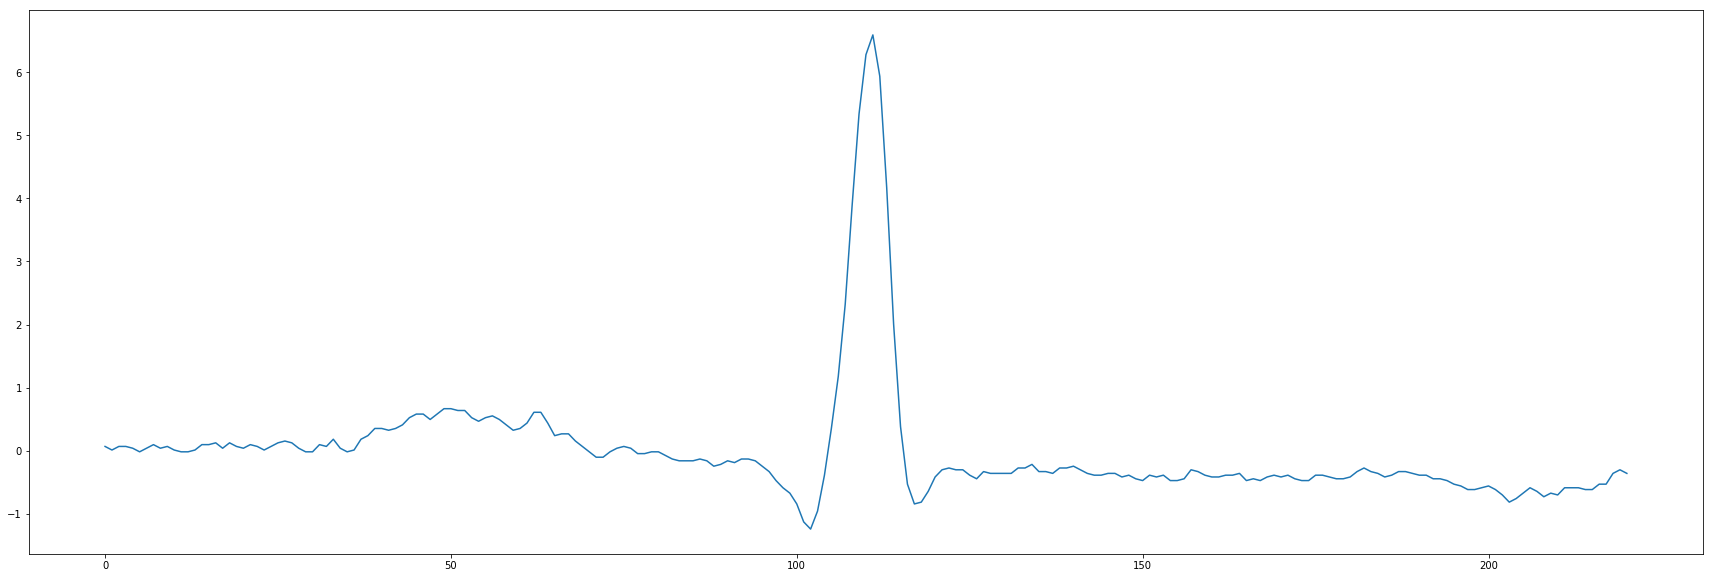

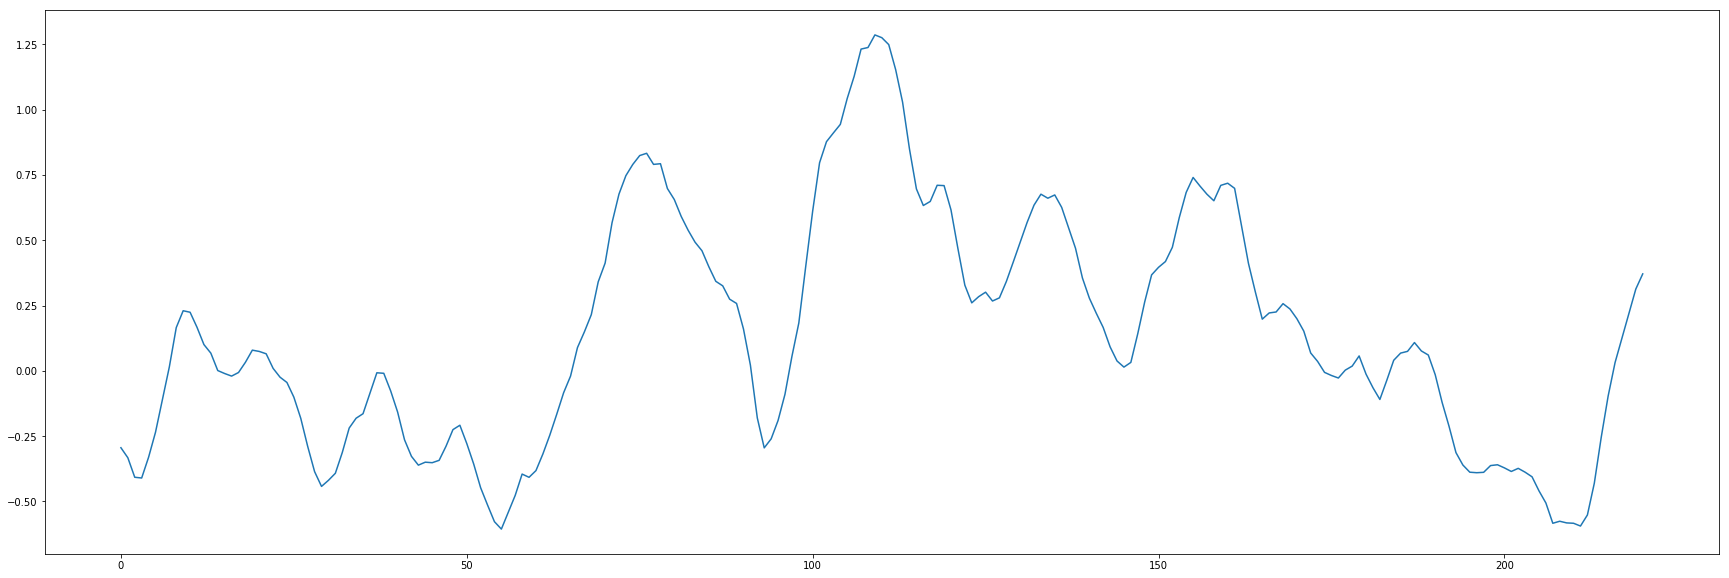

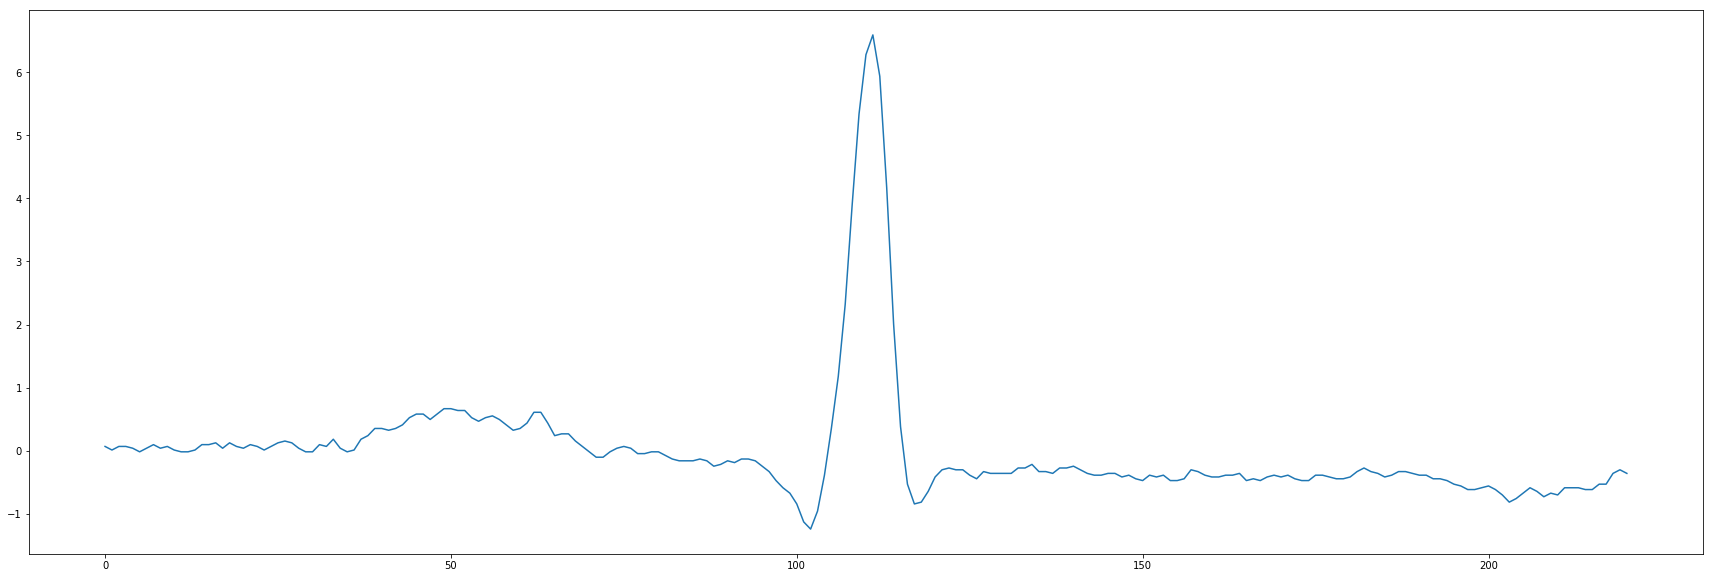

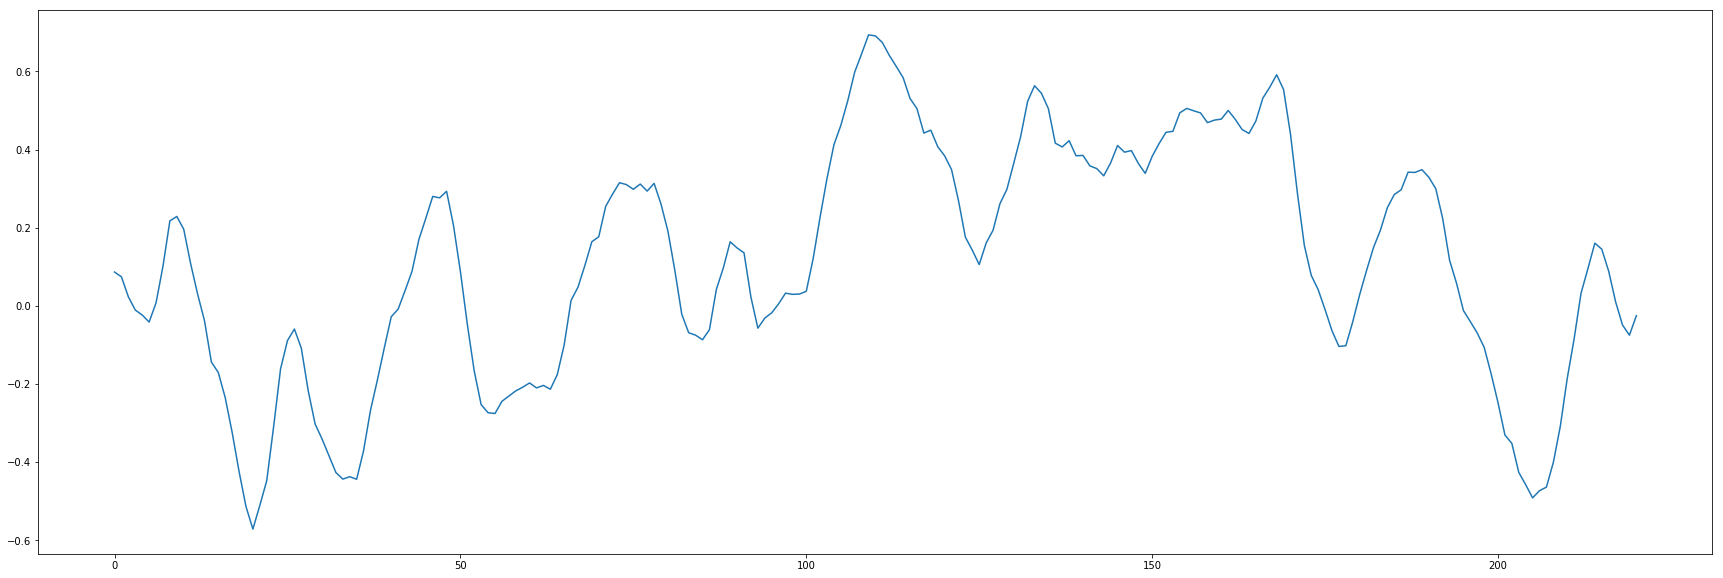

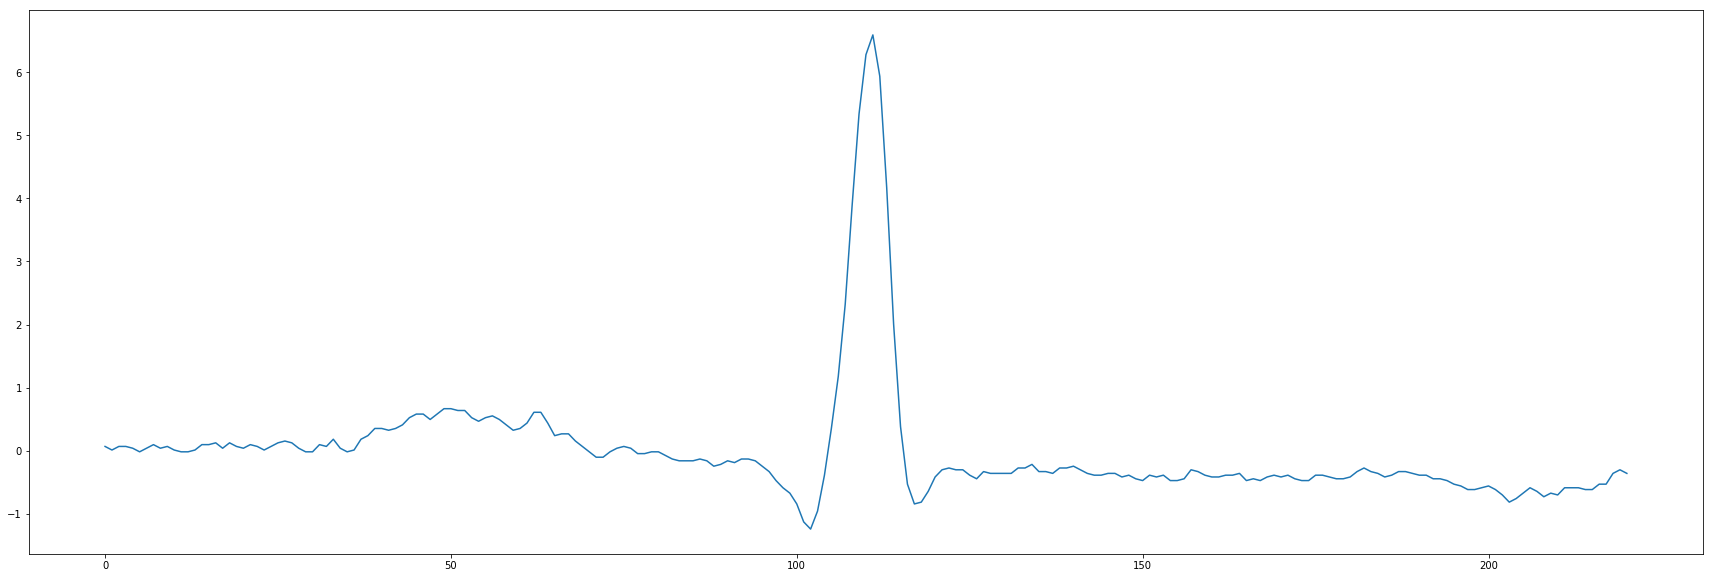

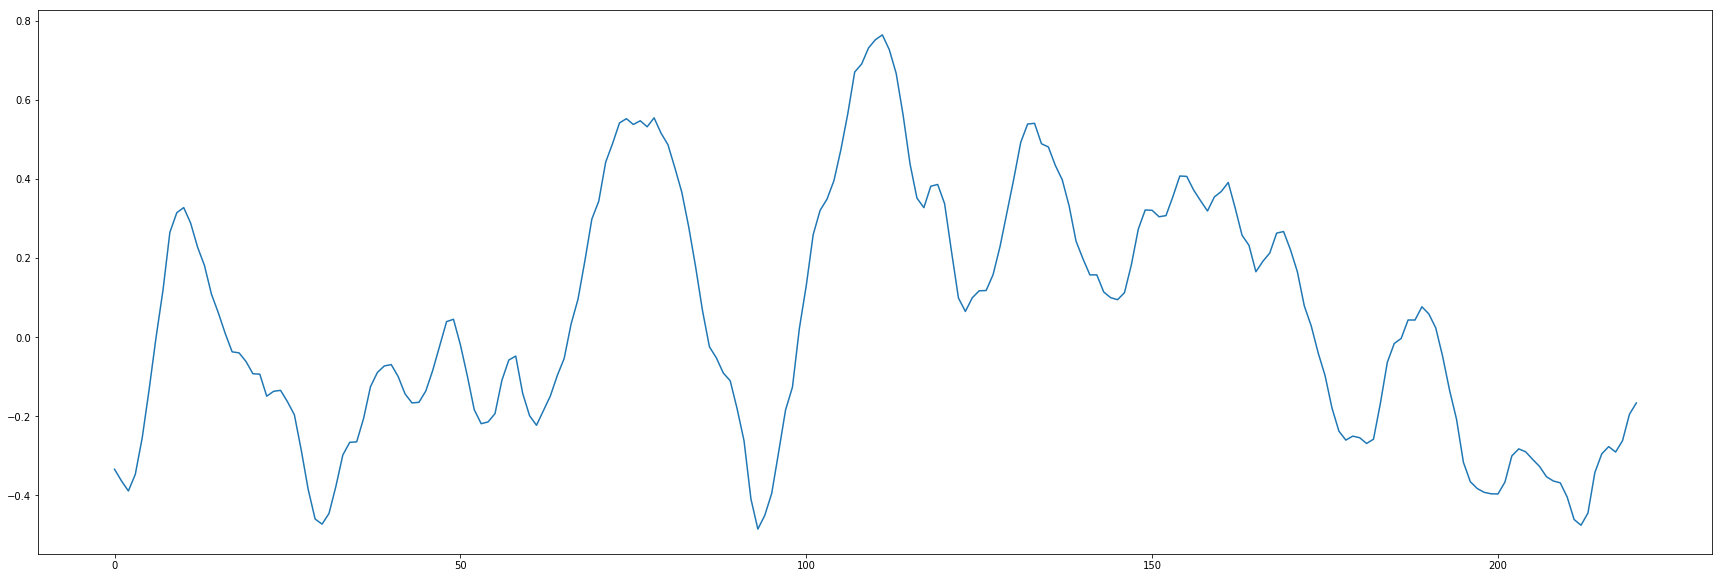

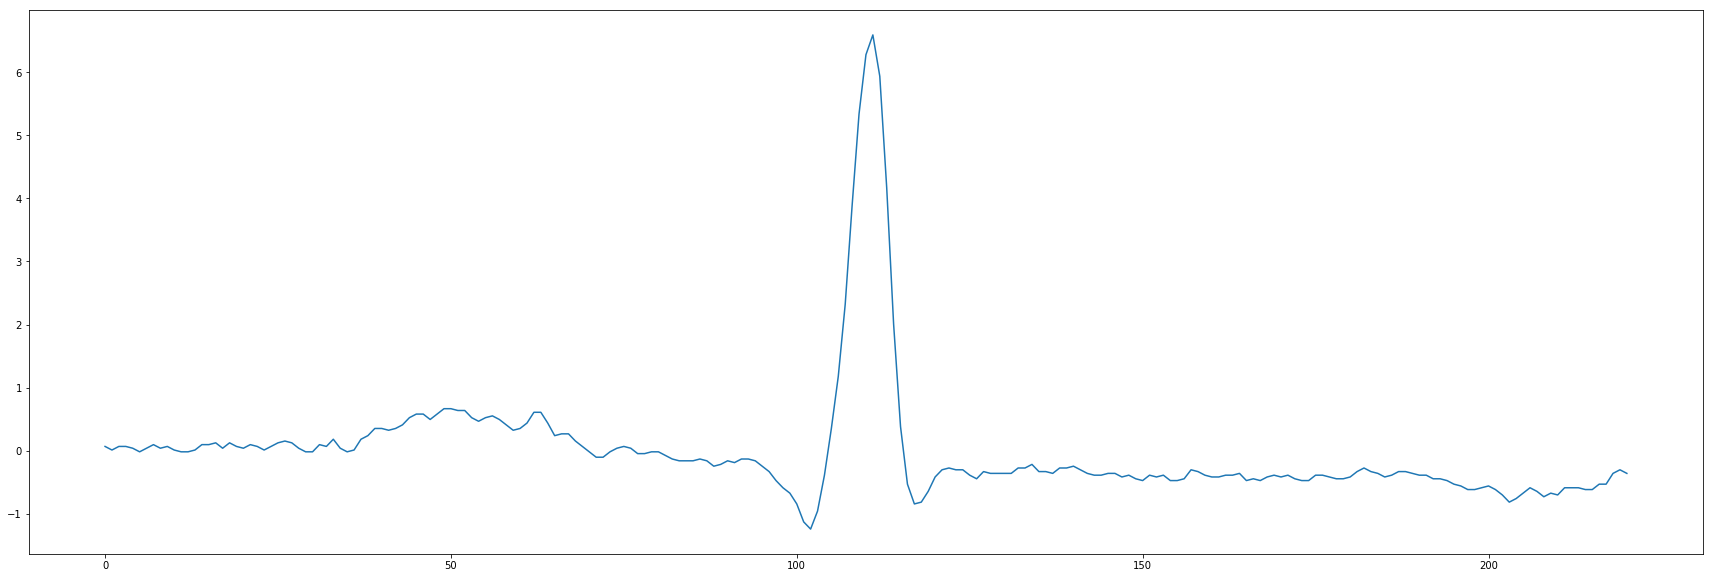

In [9]:
nrry=np.array(nrry)
arry=np.array(arry)
arryb=np.array(arryb)
tarry=np.concatenate((arry, arry, arry, arry, arry))
tnrry=np.concatenate((nrry, nrry, nrry, nrry, nrry))

LR = LinearRegression()

X_fit, X_eval, y_fit, y_eval= TTS(normalt1, nrry, test_size=0.15, random_state=1)

a = LR.fit(X=X_fit, y=y_fit)
b = LR.predict(X_eval)
c = LR.score(X_eval,y_eval)

plt.figure(figsize=(30,10))
plt.plot(b[0])
plt.figure(figsize=(30,10))
plt.plot(nrry[0])
print('The R2 score for LR using raw first window input is: '+str(c))

X_fit, X_eval, y_fit, y_eval= TTS(fnormalt1, nrry, test_size=0.15, random_state=1)

a = LR.fit(X=X_fit, y=y_fit)
b = LR.predict(X_eval)
c = LR.score(X_eval,y_eval)

plt.figure(figsize=(30,10))
plt.plot(b[0])
plt.figure(figsize=(30,10))
plt.plot(nrry[0])
print('The R2 score for LR using transformed first window input is: '+str(c))

X_fit, X_eval, y_fit, y_eval= TTS(coefn1, nrry, test_size=0.15, random_state=1)

a = LR.fit(X=X_fit, y=y_fit)
b = LR.predict(X_eval)
c = LR.score(X_eval,y_eval)

plt.figure(figsize=(30,10))
plt.plot(b[0])
plt.figure(figsize=(30,10))
plt.plot(nrry[0])
print('The R2 score for LR using PCA weights of first window input is: '+str(c))

X_fit, X_eval, y_fit, y_eval= TTS(coeff1, nrry, test_size=0.15, random_state=1)

a = LR.fit(X=X_fit, y=y_fit)
b = LR.predict(X_eval)
c = LR.score(X_eval,y_eval)

plt.figure(figsize=(30,10))
plt.plot(b[0])
plt.figure(figsize=(30,10))
plt.plot(nrry[0])
print('The R2 score for LR using PCA weights of transformed first window input is: '+str(c))

X_fit, X_eval, y_fit, y_eval= TTS(alln, nrry, test_size=0.15, random_state=1)

a = LR.fit(X=X_fit, y=y_fit)
b = LR.predict(X_eval)
c = LR.score(X_eval,y_eval)

plt.figure(figsize=(30,10))
plt.plot(b[0])
plt.figure(figsize=(30,10))
plt.plot(nrry[0])
print('The R2 score for LR using all raw inputs is: '+str(c))

X_fit, X_eval, y_fit, y_eval= TTS(allf, nrry, test_size=0.15, random_state=1)

a = LR.fit(X=X_fit, y=y_fit)
b = LR.predict(X_eval)
c = LR.score(X_eval,y_eval)

plt.figure(figsize=(30,10))
plt.plot(b[0])
plt.figure(figsize=(30,10))
plt.plot(nrry[0])
print('The R2 score for LR using all transformed input is: '+str(c))

X_fit, X_eval, y_fit, y_eval= TTS(coefn, nrry, test_size=0.15, random_state=1)

a = LR.fit(X=X_fit, y=y_fit)
b = LR.predict(X_eval)
c = LR.score(X_eval,y_eval)

plt.figure(figsize=(30,10))
plt.plot(b[0])
plt.figure(figsize=(30,10))
plt.plot(nrry[0])
print('The R2 score for LR using PCA weights of all raw input is: '+str(c))

X_fit, X_eval, y_fit, y_eval= TTS(coeff, nrry, test_size=0.15, random_state=1)

a = LR.fit(X=X_fit, y=y_fit)
b = LR.predict(X_eval)
c = LR.score(X_eval,y_eval)

plt.figure(figsize=(30,10))
plt.plot(b[0])
plt.figure(figsize=(30,10))
plt.plot(nrry[0])
print('The R2 score for LR using PCA weights of all transformed input is: '+str(c))



Below is the example pipeline/gridsearch from KDnuggets adapted to our use.

In [27]:
X_train, X_test, y_train, y_test= TTS(alln, np.ravel(arryb).astype('int'), test_size=0.15, random_state=1)
X_trainb=[]
X_testb=[]
y_trainb=[]
y_testb=[]
for i in range(len(X_train)):
    if i % 5 == 0:
        X_trainb.append(X_train[i])
        y_trainb.append(y_train[i])
for t in range(len(X_test)):
    if t % 5 == 0:
        X_testb.append(X_test[t])
        y_testb.append(y_test[t])
X_trainb = np.array(X_trainb)
X_testb = np.array(X_testb)
y_trainb = np.array(y_trainb)
y_testb = np.array(y_testb)

# Construct some pipelines
pipe_lr = Pipeline([('scl', StandardScaler()),
            ('clf', LogisticRegression(random_state=42))])

pipe_lr_pca = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=int(len(normalt1[0])/2))),
            ('clf', LogisticRegression(random_state=42))])

pipe_rf = Pipeline([('scl', StandardScaler()),
            ('clf', RFC(random_state=42))])

pipe_rf_pca = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=int(len(normalt1[0])/2))),
            ('clf', RFC(random_state=42))])

pipe_svm = Pipeline([('scl', StandardScaler()),
            ('clf', svm.SVC(random_state=42))])

pipe_svm_pca = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=int(len(normalt1[0])/2))),
            ('clf', svm.SVC(random_state=42))])

# Set grid search params
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range_fl = [1.0, 0.5, 0.1]

grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
        'clf__C': param_range_fl,
        'clf__solver': ['liblinear']}] 

grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
        'clf__min_samples_leaf': param_range,
        'clf__max_depth': param_range,
        'clf__min_samples_split': param_range[1:]}]

grid_params_svm = [{'clf__kernel': ['linear', 'rbf'], 
        'clf__C': param_range}]

# Construct grid searches
jobs = -1

gs_lr = GridSearchCV(estimator=pipe_lr,
            param_grid=grid_params_lr,
            scoring='accuracy',
            cv=10) 

gs_lr_pca = GridSearchCV(estimator=pipe_lr_pca,
            param_grid=grid_params_lr,
            scoring='accuracy',
            cv=10)

gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=grid_params_rf,
            scoring='accuracy',
            cv=10, 
            n_jobs=jobs)

gs_rf_pca = GridSearchCV(estimator=pipe_rf_pca,
            param_grid=grid_params_rf,
            scoring='accuracy',
            cv=10, 
            n_jobs=jobs)

gs_svm = GridSearchCV(estimator=pipe_svm,
            param_grid=grid_params_svm,
            scoring='accuracy',
            cv=10,
            n_jobs=jobs)

gs_svm_pca = GridSearchCV(estimator=pipe_svm_pca,
            param_grid=grid_params_svm,
            scoring='accuracy',
            cv=10,
            n_jobs=jobs)

# List of pipelines for ease of iteration
grids = [gs_lr, gs_lr_pca, gs_rf, gs_rf_pca, gs_svm, gs_svm_pca]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Logistic Regression', 1: 'Logistic Regression w/PCA', 
        2: 'Random Forest', 3: 'Random Forest w/PCA', 
        4: 'Support Vector Machine', 5: 'Support Vector Machine w/PCA'}

# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])	
    # Fit grid search	
    gs.fit(X_trainb, y_trainb)
    # Best params
    print('Best params: %s' % gs.best_params_)
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
    # Predict on test data with best params
    y_pred = gs.predict(X_testb)
    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_testb, y_pred))
    # Track best (highest test accuracy) model
    if accuracy_score(y_testb, y_pred) > best_acc:
        best_acc = accuracy_score(y_testb, y_pred)
        best_gs = gs
        best_clf = idx
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

Performing model optimizations...

Estimator: Logistic Regression
Best params: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best training accuracy: 0.533
Test set accuracy score for best params: 0.544 

Estimator: Logistic Regression w/PCA
Best params: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best training accuracy: 0.507
Test set accuracy score for best params: 0.555 

Estimator: Random Forest
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 10}
Best training accuracy: 0.607
Test set accuracy score for best params: 0.609 

Estimator: Random Forest w/PCA


KeyboardInterrupt: 

2) apply feature extraction using peak detection for learning 3) Filter the data more? 4) pickle the dataset for sharing 5)XGboost pipline 6) Add binary to label data 7) Create datasets using time varying features for more samples and more time independent alignment of features.

(3027,)